In [107]:
import pysam
import deepchopper
from deepchopper import (
    remove_intervals_and_keep_left,
)
from deepchopper.utils import highlight_targets
from pathlib import Path
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt
import logging
from rich.logging import RichHandler
from needletail import (
    parse_fastx_file,
    NeedletailError,
)

import seaborn as sns
import re
from textwrap import wrap
import gget

FORMAT = "%(message)s"
logging.basicConfig(
    level=logging.WARN,
    format=FORMAT,
    handlers=[RichHandler()],
)


INTERNAL_THRESHOLD: float = 0.9
OVERLAP_THRESHOLD: float = 0.4
BLAT_THRESHOLD: float = 0.9
MIN_MAPPING_QUALITY: int = 0


@dataclass
class FqRecord:
    id: str
    seq: str
    qual: str

    def to_str(self):
        return f"{self.id}\n{self.seq}\n+\n{self.qual}"


def vis_qual_static(predict, start: int | None = None, end: int | None = None, figure_size=(20, 1)):
    if predict.qual is None:
        raise ValueError("no qual, please fetch qual first")

    start = 0 if start is None else start
    end = len(predict.seq) if end is None else end

    qual = np.array([ord(c) - 33 for c in list(predict.qual[start:end])]).reshape(1, -1)
    seq = list(predict.seq[start:end])

    # Creating the heatmap
    fig, ax = plt.subplots(figsize=figure_size)  # Set a wide figure to accommodate the sequence
    cax = ax.imshow(qual, aspect="auto", cmap="viridis")
    cbar = plt.colorbar(cax, ax=ax, orientation="vertical")
    cbar.set_label("Value")
    # Setting up the sequence as x-axis labels
    ax.set_xticks(np.arange(len(seq)))
    ax.set_xticklabels(seq, rotation=90)  # Rotate labels for better readability
    # Remove y-axis labels as there's only one row
    ax.set_yticks([])
    ax.set_title(f"{predict.id}: {start}-{end}")
    plt.show()
    plt.close()


def to_fqs_record(predict, intervals: list[tuple[int, int]]):
    if predict.qual is None:
        raise ValueError("no qual, please fetch qual first")

    assert len(predict.qual) == len(predict.seq)

    seqs, saved_intervals = remove_intervals_and_keep_left(predict.seq, intervals)
    quals, saved_intervals = remove_intervals_and_keep_left(predict.qual, intervals)

    assert len(seqs) == len(quals)
    for ind, (seq, qual) in enumerate(zip(seqs, quals, strict=True)):
        record_id = f"@{predict.id}|{saved_intervals[ind][0], saved_intervals[ind][1]}"
        yield FqRecord(id=record_id, seq=seq, qual=qual)


def smooth_and_select_intervals(
    predict_id,
    stats,
    smooth_window_size: int,
    min_interval_length: int,
    approved_interval_nums: int = 1,
) -> list[tuple[int, int]]:
    chop_intervals = stats.smooth_intervals[predict_id]

    results = []
    for interval in chop_intervals:
        if interval[1] - interval[0] > min_interval_length:
            results.append(interval)

    if len(results) > approved_interval_nums:
        return []

    return results


def collect_fq_records(file: Path):
    result = {}
    try:
        for record in parse_fastx_file(file.as_posix()):
            result[record.id] = record
    except NeedletailError:
        print("Invalid Fastq file")

    return result


def collect_sam_records(file: Path):
    if not isinstance(file, Path):
        file = Path(file)

    result = {}
    samfile = pysam.AlignmentFile(file.as_posix(), "rb")

    for read in samfile.fetch():
        result[read.query_name] = read

    return result


def vis_hist_for_num_of_intervals(data, figsize=(10, 6), title=None, ax=None, set_xticks=False):
    # Create histogram with a kernel density estimate
    max_x = max(data) + 1
    if ax is None:
        plt.figure(figsize=figsize)
        sns.histplot(data, kde=True, color="#66c2a5", line_kws={"linewidth": 2}, discrete=True)
        if set_xticks:
            plt.xticks(range(0, max_x, 1))
        plt.title(title)
        plt.xlabel("Value")
        plt.ylabel("Frequency")
    else:
        sns.histplot(
            data,
            kde=True,
            color="#66c2a5",
            line_kws={"linewidth": 2},
            discrete=True,
            ax=ax,
        )
        ax.set_title(title)
        if set_xticks:
            ax.set_xticks(range(0, max_x, 1))
        ax.set_xlabel("Value")
        ax.set_ylabel("Frequency")


def wrap_str(ostr, width):
    return "\n".join(wrap(ostr, width))


def show_sam_record(predict, stats, sam_records):
    seq_len = len(predict.seq)
    txt_width = 120

    print(f"\nread id {predict.id} seq len: {seq_len}")

    smooth_intervals = stats.smooth_intervals[predict.id]

    for interval in smooth_intervals:
        quals = predict.qual_array()[interval[0] : interval[1]]
        average_qual = sum(quals) / len(quals)
        print(f"smooth interval : {interval} len: {interval[1] - interval[0]}     {average_qual=}")

    highlight_targets(predict.seq, predict.prediction_region())
    highlight_targets(predict.seq, smooth_intervals)

    predict_read = sam_records.get(predict.id, None)
    if predict_read is None:
        print("the read is not map")
        return

    if len(smooth_intervals) == 1:
        blat_df = gget.blat(predict.seq[smooth_intervals[0][0] : smooth_intervals[0][1]])
        if blat_df is not None:
            print(f"blat result:\n {blat_df.to_string()}\n")

    print(
        f"{predict_read.reference_id=} strand={'+' if predict_read.is_forward else '-'} {predict_read.mapping_quality=}"
    )
    print(f"{predict_read.reference_start=} {predict_read.reference_end=}")
    print(f"cigar: {wrap_str(predict_read.cigarstring, txt_width)}")

    ls_len, rs_len = deepchopper.left_right_soft_clip(predict_read.cigarstring)
    if not predict_read.is_forward:
        ls_len, rs_len = rs_len, ls_len

    print(f"ls: 0-{ls_len}  \n {wrap_str(predict.seq[:ls_len], txt_width)}")
    print(f"rs: {seq_len-rs_len}-{seq_len} \n {wrap_str(predict.seq[-rs_len:], txt_width)}")

    if predict_read.has_tag("SA"):
        print("has sa")
        chimeric_alns = predict_read.get_tag("SA")[:-1].split(";")

        for _aln in chimeric_alns:
            (
                chr_sa,
                pos_sa,
                strand_sa,
                cigar_sa,
                mapq_sa,
                nm_sa,
            ) = _aln.split(",")

            left_mat = pat_left_s.search(cigar_sa)
            right_mat = pat_right_s.search(cigar_sa)

            l_s_len = left_mat.group(1) if left_mat else ""
            r_s_len = right_mat.group(1) if right_mat else ""

            tgt_key = f"{predict_read.qname}\t{l_s_len=}\t{r_s_len=}"

            print(f"chimeric : {tgt_key}")


def check_overlap(
    interval1: tuple[int, int], interval2: tuple[int, int], overlap_threshold: float
) -> bool:
    # interval2 is predicted region

    start1, end1 = interval1
    start2, end2 = interval2

    length1 = end1 - start1
    length2 = end2 - start2

    # Calculate the maximum start point and minimum end point
    max_start = max(start1, start2)
    min_end = min(end1, end2)

    # union
    min_start = min(start1, start2)
    max_end = max(end1, end2)

    # Calculate the overlap length
    overlap = max(0, min_end - max_start)

    divide = length2

    ratio = overlap / divide

    # Check if the overlap meets or exceeds the threshold
    print(f"compare {interval1}({length1}) {interval2}({length2}) {ratio=}")
    return ratio >= overlap_threshold


def process_one_interval_parallel(
    overlap_results,
    whole_seq_len: int,
    pseq,
    pid,
    ls_len: int,
    rs_len: int,
    pd_start: int,
    pd_end: int,
    overlap_threshold: float,
    internal_threshold: float,
    blat_threshold: float,
    read_mp: int,
    min_mapping_quality: int,
):
    predict_seq = pseq[pd_start:pd_end]
    min_blat_seq_len = 20

    if pd_end / whole_seq_len > internal_threshold:
        # terminal adapter
        # has overlap
        if check_overlap(
            (whole_seq_len - rs_len, whole_seq_len),
            (pd_start, pd_end),
            overlap_threshold,
        ):
            overlap_results["terminal_chop_sc"].append(pid)
        else:
            overlap_results["terminal_chop_nosc"].append(pid)
            if len(predict_seq) < min_blat_seq_len:
                overlap_results["terminal_chop_nosc_cannot_blat"].append(pid)
                return

            blat_df = gget.blat(predict_seq)
            if blat_df is not None:
                print(f"\nblat_df: {blat_df.to_string()}\n")
            else:
                print("blat_df is None")

            if blat_df is None or (blat_df.iloc[0]["%_aligned"] / 100 < blat_threshold):
                overlap_results["terminal_chop_nosc_noblat"].append(pid)

    else:  # internal adapter
        flag = False
        if ls_len != 0:
            if check_overlap((0, ls_len), (pd_start, pd_end), overlap_threshold):
                flag = True
                overlap_results["internal_chop_sc"].append(pid)

        if rs_len != 0 and not flag:
            if check_overlap(
                (whole_seq_len - rs_len, whole_seq_len),
                (pd_start, pd_end),
                overlap_threshold,
            ):
                flag = True
                overlap_results["internal_chop_sc"].append(pid)

        if not flag:
            overlap_results["internal_chop_nosc"].append(pid)

            if len(predict_seq) < min_blat_seq_len:
                # seq is too short, and cannot use blat
                overlap_results["internal_chop_nosc_cannot_blat"].append(pid)
                return

            blat_df = gget.blat(predict_seq)
            if blat_df is not None:
                print(f"\nblat_df: {blat_df.to_string()}\n")
            else:
                print("blat_df is None")

            if blat_df is None or (blat_df.iloc[0]["%_aligned"] / 100 < blat_threshold):
                overlap_results["internal_chop_nosc_noblat"].append(pid)




def verify_result_with_sam_records_rs(
    overlap_results,
    predict,
    stats,
    rs_read,
    internal_threshold: float = INTERNAL_THRESHOLD,
    overlap_threshold: float = OVERLAP_THRESHOLD,
    blat_threshold: float = BLAT_THRESHOLD,
    min_mapping_quality: int = MIN_MAPPING_QUALITY,
):
    read_mapping_quality = rs_read.mapping_quality
    
    if not rs_read.is_mapped:
        print(f"\nthe read {predict.id} is not map")
        overlap_results["unmap_read"].append(predict.id)
        return

    if read_mapping_quality < min_mapping_quality:
        print(f"\nthe read {predict.id}'s mapping_quality {read_mapping_quality} is low")
        overlap_results["low_mp_read"].append(predict.id)
        return

    seq_len = len(predict.seq)

    ls_len, rs_len = rs_read.left_softclip, rs_read.right_softclip

    intervals = stats.smooth_intervals[predict.id]

    print("\n")
    print(predict.show_info(intervals))

    txt_width = 120
    print(
        f"strand={'+' if rs_read.is_forward else '-'} {rs_read.mapping_quality=}"
    )
    # print(f"{predict_read.reference_start=} {predict_read.reference_end=}")
    print(f"cigar: {wrap_str(rs_read.cigar, txt_width)}")
    print(f"ls {ls_len}: 0-{ls_len}  \n {wrap_str(predict.seq[:ls_len], txt_width)}")
    print(
        f"rs {rs_len}: {seq_len-rs_len}-{seq_len} \n {wrap_str(predict.seq[seq_len-rs_len:seq_len], txt_width)}"
    )
    

    if len(intervals) == 1:
        # clean predict
        start, end = intervals[0]
        # quals = predict.qual_array()[start:end]
        # average_qual = sum(quals) / len(quals)
        process_one_interval_parallel(
            overlap_results,
            seq_len,
            predict.seq,
            predict.id,
            ls_len,
            rs_len,
            start,
            end,
            overlap_threshold,
            internal_threshold,
            blat_threshold,
            read_mapping_quality,
            min_mapping_quality,
        )
    elif len(intervals) <= 3:
        for interval in intervals:
            start, end = interval
            process_one_interval_parallel(
                overlap_results,
                seq_len,
                predict.seq,
                predict.id,
                ls_len,
                rs_len,
                start,
                end,
                overlap_threshold,
                internal_threshold,
                blat_threshold,
                read_mapping_quality,
                min_mapping_quality,
            )
    else:
        overlap_results["no_process"].append(predict.id)
        pass



from collections import defaultdict


def verify_result_with_sam_records_for_parallel(
    pseq: str,
    pid: str,
    smooth_intervals: dict[str, list[tuple[int, int]]],
    read_is_mapped: bool,
    read_mapping_quality: int,
    read_left_softclip: int,
    read_right_softclip: int,
    internal_threshold: float = INTERNAL_THRESHOLD,
    overlap_threshold: float = OVERLAP_THRESHOLD,
    blat_threshold: float = BLAT_THRESHOLD,
    min_mapping_quality: int = MIN_MAPPING_QUALITY,
):
    overlap_results = defaultdict(list)
    read_mapping_quality = read_mapping_quality

    if not read_is_mapped:
        print(f"\nthe read {pid} is not map")
        overlap_results["unmap_read"].append(pid)
        return overlap_results

    if read_mapping_quality < min_mapping_quality:
        print(f"\nthe read {pid}'s mapping_quality {read_mapping_quality} is low")
        overlap_results["low_mp_read"].append(pid)
        return overlap_results

    seq_len = len(pseq)
    ls_len, rs_len = read_left_softclip, read_right_softclip
    intervals = smooth_intervals[pid]

    if len(intervals) == 1:
        # clean predict
        start, end = intervals[0]
        
        process_one_interval_parallel(
            overlap_results,
            seq_len,
            pseq,
            pid,
            ls_len,
            rs_len,
            start,
            end,
            overlap_threshold,
            internal_threshold,
            blat_threshold,
            read_mapping_quality,
            min_mapping_quality,
        )
    elif len(intervals) <= 3:
        for interval in intervals:
            start, end = interval
            process_one_interval_parallel(
                overlap_results,
                seq_len,
                pseq,
                pid,
                ls_len,
                rs_len,
                start,
                end,
                overlap_threshold,
                internal_threshold,
                blat_threshold,
                read_mapping_quality,
                min_mapping_quality,
            )
    else:
        overlap_results["no_process"].append(pid)
        
    return overlap_results


def merge_results(results_list):
    combined_results = defaultdict(list)
    for single_result in results_list:
        for key, values in single_result.items():
            combined_results[key].extend(values)
    return combined_results

In [108]:
def verify_result_with_sam_records(
    overlap_results,
    predict,
    stats,
    sam_records,
    internal_threshold: float = INTERNAL_THRESHOLD,
    overlap_threshold: float = OVERLAP_THRESHOLD,
    blat_threshold: float = BLAT_THRESHOLD,
    min_mapping_quality: int = MIN_MAPPING_QUALITY,
):
    predict_read = sam_records.get(predict.id, None)

    if predict_read is None:
        print(f"\nthe read {predict.id} is not map")
        overlap_results["unmap_read"].append(predict.id)
        return

    if predict_read.mapping_quality < min_mapping_quality:
        print(f"\nthe read {predict.id}'s mapping_quality {predict_read.mapping_quality} is low")
        overlap_results["low_mp_read"].append(predict.id)
        return

    seq_len = len(predict.seq)

    ls_len, rs_len = deepchopper.left_right_soft_clip(predict_read.cigarstring)

    intervals = stats.smooth_intervals[predict.id]

    if not predict_read.is_forward:
        ls_len, rs_len = rs_len, ls_len

    # highlight_targets(predict.seq, intervals)
    print("\n")
    print(predict.show_info(intervals))

    txt_width = 120
    print(
        f"{predict_read.reference_id=} strand={'+' if predict_read.is_forward else '-'} {predict_read.mapping_quality=}"
    )
    print(f"{predict_read.reference_start=} {predict_read.reference_end=}")
    print(f"cigar: {wrap_str(predict_read.cigarstring, txt_width)}")
    print(f"ls {ls_len}: 0-{ls_len}  \n {wrap_str(predict.seq[:ls_len], txt_width)}")
    print(
        f"rs {rs_len}: {seq_len-rs_len}-{seq_len} \n {wrap_str(predict.seq[seq_len-rs_len:seq_len], txt_width)}"
    )

    # if predict_read.has_tag("SA"):

    if len(intervals) == 1:
        # clean predict
        start, end = intervals[0]
        # quals = predict.qual_array()[start:end]
        # average_qual = sum(quals) / len(quals)
        process_one_interval_parallel(
            overlap_results,
            seq_len,
            predict.seq,
            predict.id,
            ls_len,
            rs_len,
            start,
            end,
            overlap_threshold,
            internal_threshold,
            blat_threshold,
            predict_read.mapping_quality,
            min_mapping_quality,
        )
    elif len(intervals) <= 3:
        for interval in intervals:
            start, end = interval
            process_one_interval_parallel(
                overlap_results,
                seq_len,
                predict.seq,
                predict.id,
                ls_len,
                rs_len,
                start,
                end,
                overlap_threshold,
                internal_threshold,
                blat_threshold,
                predict_read.mapping_quality,
                min_mapping_quality,
            )
    else:
        overlap_results["no_process"].append(predict.id)
        pass


In [109]:
print("done")

done


In [29]:
# %%time
# overlap_results = defaultdict(list)

# for p in stats.smooth_internal_predicts[:100]:
#     verify_result_with_sam_records_rs(
#     overlap_results,
#     all_predicts[p],
#     stats,
#     rs_sam_records[p])

**TODO**: 

- [ ] summary chop  or not chop
- [ ] summary chop internal or terminal
- [ ] chop only has one interval
- [ ] summary chop interval size

In [36]:
# %%time
# sam_records = collect_sam_records("/projects/b1171/ylk4626/project/DeepChopper/data/eval/real_data/dorado_without_trim_fqs/VCaP.bam")

In [110]:
# len(sam_records)

In [6]:
%%time
rs_sam_records = deepchopper.read_bam_records_parallel("/projects/b1171/ylk4626/project/DeepChopper/data/eval/real_data/dorado_without_trim_fqs/VCaP.bam")

CPU times: user 7min 44s, sys: 1min 53s, total: 9min 37s
Wall time: 1min 9s


In [7]:
len(rs_sam_records)

9177639

In [9]:
test_chunks = [Path("/projects/b1171/ylk4626/project/DeepChopper/tests/data/eval/chunk0"),
               Path("/projects/b1171/ylk4626/project/DeepChopper/tests/data/eval/chunk1")]       

In [30]:
fq_records = collect_fq_records(Path("/projects/b1171/ylk4626/project/DeepChopper/data/eval/real_data/dorado_without_trim_fqs/VCaP.fastq"))

In [31]:
len(fq_records)

9177639

In [111]:
## VCaP
hyena_results = [
Path("/projects/b1171/ylk4626/project/DeepChopper/logs/eval/runs/vcap/VCaP.fastq_0/predicts/0/"),
Path("/projects/b1171/ylk4626/project/DeepChopper/logs/eval/runs/vcap/VCaP.fastq_1/predicts/0/"),
Path("/projects/b1171/ylk4626/project/DeepChopper/logs/eval/runs/vcap/VCaP.fastq_2/predicts/0/"),
Path("/projects/b1171/ylk4626/project/DeepChopper/logs/eval/runs/vcap/VCaP.fastq_3/predicts/0/"),
Path("/projects/b1171/ylk4626/project/DeepChopper/logs/eval/runs/vcap/VCaP.fastq_4/predicts/0/"),
Path("/projects/b1171/ylk4626/project/DeepChopper/logs/eval/runs/vcap/VCaP.fastq_5/predicts/0/"),
Path("/projects/b1171/ylk4626/project/DeepChopper/logs/eval/runs/vcap/VCaP.fastq_6/predicts/0/"),
Path("/projects/b1171/ylk4626/project/DeepChopper/logs/eval/runs/vcap/VCaP.fastq_7/predicts/0/"),
Path("/projects/b1171/ylk4626/project/DeepChopper/logs/eval/runs/vcap/VCaP.fastq_8/predicts/0/"),
Path("/projects/b1171/ylk4626/project/DeepChopper/logs/eval/runs/vcap/VCaP.fastq_9/predicts/0/"),
]

In [112]:
max_batches  =  5000
all_predicts = deepchopper.load_predicts_from_batch_pts(hyena_results[0],
                                                        -100, 
                                                        max_batches)

Thu Apr 25 01:48:47 2024 INFO Found 31250 pt files
Thu Apr 25 01:48:47 2024 INFO only load first 5000 pt files


In [114]:
len(all_predicts)

160000

In [115]:
%%time
stats = deepchopper.py_collect_statistics_for_predicts_parallel(
    list(all_predicts.values()),
    smooth_window_size=21,
    min_interval_size=10,
    approved_interval_number=10,
    internal_threshold=INTERNAL_THRESHOLD,
    ploya_threshold=3,
)
stats

CPU times: user 1min 36s, sys: 660 ms, total: 1min 36s
Wall time: 1.64 s


StatResult(total_predicts: 150950,  predicts_with_chop: 141119, smooth_predicts_with_chop: 138523,
                        smooth_internal_predicts: 2769, total_truncated: 0, smooth_only_one: 136286,
                        smooth_ploya_only_one: 111419)

In [116]:
print(all_predicts[stats.predicts_with_chop[0]].show_info(stats.smooth_intervals[stats.predicts_with_chop[0]]))

id: ae92dd41-0a8a-43ed-8103-590fc20b154c
prediction: [601..678]
smooth_intervals: [(601, 678)]
CAGGCGATCCCAATCCCCACACGGTGGACAATGAGGCTGGCAAGATCACGTGCCTGTGTCAAGTCCCCCAGAATGCAGCC
AATCGGGGCTTAAAAGCCAGCGAGTGGGTGCAGCAGGTGTCAGGCTTGATGGACGGTAAAGGTGGTGGCAAGGATGTGTC
TGCACAGGCCACAGGCAAGAACGTTGGCTGCCCTGCAGGAGGCGCTGCAGCTGGCCACTCACCTTCGCCCAGCTGCGCCT
CGGGGATGTAAAGAACTGAGTGGGGAAGGAGGAGGCTCCCACTGGATCCAACTCCGTCCAGCCAAGAGCTCTTCATCTGC
TACAAGAACATTTGATCTTGGGGTTCTAAAGAGCCCTCCTAACCCAGCAGTAACTGGAACACACTTGGGAGCAGTCCTAT
GTCTCAGTGCCCCTTAAATTTCTGCCCTGAGCCCTCCACGTCAGTGCCATCGGTCTTCTAGAACCACTAACCCCGCATTG
CTGTTGATCGTCACGCTCGCATCTATAGATAACGGCTCTCCAGACCTGAGCTTTCCGCGTCAGCAAGTAGGAATCGTTTT
TGCTGCAGAGAATAAAAGGTCACGTGCAATACTTAAAAAAATCCCTCCCTCTCCCTCCATCTACCCACCATATCAATTCC
ATATCATCCCACCATCCCCACATCCCTAAATTCCCCTC

CAGGCGATCCCAATCCCCACACGGTGGACAATGAGGCTGGCAAGATCACGTGCCTGTGTCAAGTCCCCCAGAATGCAGCC
AATCGGGGCTTAAAAGCCAGCGAGTGGGTGCAGCAGGTGTCAGGCTTGATGGACGGTAAAGGTGGTGGCAAGGATGTGTC
TGCACAGGCCACAGGCAAGAACGTTGGCTGCCCTGCAGGAGGCGCTGCAGCTGGC

In [ ]:
%%time
import json
from joblib import Parallel, delayed
# # Run the processing in parallel and collect all results
results_list = Parallel(n_jobs=1)(
    delayed(verify_result_with_sam_records_for_parallel)(all_predicts[p].seq,
                                                         all_predicts[p].id,
                                                         stats.smooth_intervals, 
                                                         rs_sam_records[p].is_mapped,
                                                         rs_sam_records[p].mapping_quality ,
                                                         rs_sam_records[p].left_softclip,
                                                         rs_sam_records[p].right_softclip,
                                                         ) for p in stats.smooth_predicts_with_chop)
overlap_results = merge_results(results_list)

with open("overlap_result.json", "w") as outfile:
    json.dump(overlap_results, outfile, indent=4, sort_keys=False)

compare (596, 678)(82) (601, 678)(77) ratio=1.0
compare (2029, 2086)(57) (2032, 2086)(54) ratio=1.0
compare (565, 647)(82) (580, 647)(67) ratio=1.0
compare (433, 512)(79) (434, 512)(78) ratio=1.0
compare (795, 881)(86) (818, 881)(63) ratio=1.0
compare (791, 876)(85) (803, 876)(73) ratio=1.0
compare (470, 544)(74) (474, 544)(70) ratio=1.0
compare (2203, 2299)(96) (2205, 2299)(94) ratio=1.0
compare (640, 716)(76) (639, 716)(77) ratio=0.987012987012987
compare (1108, 1182)(74) (1108, 1182)(74) ratio=1.0
compare (3274, 3334)(60) (3277, 3334)(57) ratio=1.0

the read ac922729-356c-4212-8ccb-e37d10cd5cce is not map
compare (329, 436)(107) (365, 436)(71) ratio=1.0
compare (3598, 3678)(80) (3602, 3678)(76) ratio=1.0
compare (775, 847)(72) (780, 847)(67) ratio=1.0
compare (1296, 1375)(79) (1304, 1375)(71) ratio=1.0
compare (419, 489)(70) (432, 489)(57) ratio=1.0
compare (433, 504)(71) (433, 504)(71) ratio=1.0

the read e84aaa52-92d6-4b87-9674-0aca13009e99 is not map
compare (304, 375)(71) (315, 

Thu Apr 25 01:52:49 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (1008, 1009)(1) (946, 1009)(63) ratio=0.015873015873015872

blat_df:    genome  query_size  aligned_start  aligned_end  matches  mismatches  %_aligned  %_matched            chromosome strand      start        end
0    hg38          63              1           63       43           0     100.00      68.25                 chr10      -  132973284  132973692
1    hg38          63             38           63       25           1      41.27      96.15                  chr3      -  129381140  129381165
2    hg38          63             38           63       25           1      41.27      96.15                  chr3      -  129488093  129488118
3    hg38          63             39           63       25           0      39.68     100.00  chr14_KI270845v1_alt      +      53525      53930
4    hg38          63             11           37       25           2      42.86      92.59                 chr17      -   53150750   53150776
5    hg38          63             32           59       25 

Thu Apr 25 01:56:40 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (1160, 1244)(84) (1204, 1244)(40) ratio=1.0
compare (0, 5)(5) (628, 666)(38) ratio=0.0
compare (1599, 1671)(72) (628, 666)(38) ratio=0.0


Thu Apr 25 01:56:41 2024 INFO No DNA BLAT matches were found for this sequence in genome hg38.


blat_df is None
compare (1599, 1671)(72) (1610, 1671)(61) ratio=1.0
compare (1406, 1491)(85) (1429, 1491)(62) ratio=1.0
compare (164, 256)(92) (179, 256)(77) ratio=1.0

the read fa43eb7c-d750-497b-93dc-6fd81f95ca5c is not map
compare (1290, 1364)(74) (1292, 1364)(72) ratio=1.0
compare (811, 884)(73) (819, 884)(65) ratio=1.0
compare (498, 574)(76) (503, 574)(71) ratio=1.0
compare (686, 755)(69) (690, 755)(65) ratio=1.0
compare (499, 596)(97) (506, 596)(90) ratio=1.0
compare (506, 569)(63) (517, 569)(52) ratio=1.0
compare (5257, 5312)(55) (5263, 5312)(49) ratio=1.0
compare (412, 500)(88) (424, 500)(76) ratio=1.0
compare (365, 425)(60) (371, 425)(54) ratio=1.0
compare (435, 496)(61) (440, 496)(56) ratio=1.0
compare (541, 615)(74) (546, 615)(69) ratio=1.0
compare (2813, 2887)(74) (2821, 2887)(66) ratio=1.0
compare (536, 596)(60) (539, 596)(57) ratio=1.0
compare (398, 477)(79) (408, 477)(69) ratio=1.0
compare (2172, 2247)(75) (2173, 2247)(74) ratio=1.0
compare (1887, 1960)(73) (1903, 1960)(

Thu Apr 25 01:58:30 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (0, 4)(4) (440, 512)(72) ratio=0.0
compare (551, 2161)(1610) (440, 512)(72) ratio=0.0

blat_df:   genome  query_size  aligned_start  aligned_end  matches  mismatches  %_aligned  %_matched chromosome strand     start       end
0   hg38          72              3           26       23           0      33.33      95.83      chr17      -  41784310  41784332

compare (0, 4)(4) (1385, 1426)(41) ratio=0.0
compare (551, 2161)(1610) (1385, 1426)(41) ratio=1.0
compare (922, 1002)(80) (939, 1002)(63) ratio=1.0
compare (4093, 4176)(83) (4105, 4176)(71) ratio=1.0
compare (451, 553)(102) (463, 553)(90) ratio=1.0
compare (1737, 1787)(50) (1737, 1787)(50) ratio=1.0
compare (960, 1054)(94) (968, 1054)(86) ratio=1.0
compare (1676, 1758)(82) (1687, 1758)(71) ratio=1.0
compare (823, 919)(96) (835, 919)(84) ratio=1.0
compare (1866, 1934)(68) (1872, 1934)(62) ratio=1.0
compare (718, 793)(75) (727, 793)(66) ratio=1.0
compare (934, 1022)(88) (940, 1022)(82) ratio=1.0
compare (418, 505)(87) (438, 505)(

Thu Apr 25 01:58:53 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (1790, 1800)(10) (1728, 1800)(72) ratio=0.1388888888888889

blat_df:   genome  query_size  aligned_start  aligned_end  matches  mismatches  %_aligned  %_matched chromosome strand      start        end
0   hg38          72             16           35       20           0      27.78      100.0       chr2      +  123113279  123113298

compare (610, 671)(61) (615, 671)(56) ratio=1.0
compare (539, 621)(82) (547, 621)(74) ratio=1.0
compare (2105, 2192)(87) (2120, 2192)(72) ratio=1.0
compare (591, 666)(75) (596, 666)(70) ratio=1.0
compare (852, 918)(66) (860, 918)(58) ratio=1.0
compare (420, 493)(73) (421, 493)(72) ratio=1.0
compare (1646, 1732)(86) (1656, 1732)(76) ratio=1.0
compare (498, 574)(76) (506, 574)(68) ratio=1.0
compare (450, 516)(66) (450, 516)(66) ratio=1.0
compare (1031, 1083)(52) (1031, 1083)(52) ratio=1.0
compare (2152, 2254)(102) (2170, 2254)(84) ratio=1.0
compare (338, 413)(75) (348, 413)(65) ratio=1.0


Thu Apr 25 01:58:58 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (607, 700)(93) (621, 700)(79) ratio=1.0
compare (7840, 7964)(124) (7204, 7354)(150) ratio=0.0

blat_df:   genome  query_size  aligned_start  aligned_end  matches  mismatches  %_aligned  %_matched chromosome strand     start       end
0   hg38         150             56           82       27           0      18.00      100.0       chr1      -  15652059  15652085
1   hg38         150             65           84       20           0      13.33      100.0      chr12      -   1653068   1653087

compare (281, 358)(77) (289, 358)(69) ratio=1.0

the read 9ea4a37a-9a14-4b41-8620-6ee1f6eb74e5 is not map
compare (797, 845)(48) (802, 845)(43) ratio=1.0
compare (493, 572)(79) (509, 572)(63) ratio=1.0
compare (676, 758)(82) (684, 758)(74) ratio=1.0
compare (447, 505)(58) (451, 505)(54) ratio=1.0

the read b9db150e-042e-42e3-80cf-f0fa990142c1 is not map
compare (687, 767)(80) (693, 767)(74) ratio=1.0
compare (1309, 1402)(93) (1330, 1402)(72) ratio=1.0
compare (478, 561)(83) (488, 561)(73) rat

Thu Apr 25 02:00:28 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (1278, 1361)(83) (1199, 1305)(106) ratio=0.25471698113207547

blat_df:   genome  query_size  aligned_start  aligned_end  matches  mismatches  %_aligned  %_matched chromosome strand      start        end
0   hg38         106             31           63       30           3      31.13      90.91       chr3      +  104682739  104682771
1   hg38         106             63           91       26           0      27.36      89.66      chr11      -   13075444   13075482
2   hg38         106             58           80       23           0      21.70     100.00      chr12      -   28747095   28747122
3   hg38         106             54           73       20           0      18.87     100.00      chr13      +   61838632   61838651

compare (1278, 1361)(83) (1329, 1361)(32) ratio=1.0
compare (2823, 2911)(88) (2831, 2911)(80) ratio=1.0
compare (470, 547)(77) (475, 547)(72) ratio=1.0
compare (387, 478)(91) (394, 478)(84) ratio=1.0
compare (691, 795)(104) (718, 795)(77) ratio=1.0
compare (69

Thu Apr 25 02:01:23 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (459, 538)(79) (68, 136)(68) ratio=0.0


Thu Apr 25 02:01:24 2024 INFO No DNA BLAT matches were found for this sequence in genome hg38.


blat_df is None
compare (459, 538)(79) (466, 538)(72) ratio=1.0
compare (820, 900)(80) (829, 900)(71) ratio=1.0
compare (955, 1032)(77) (971, 1032)(61) ratio=1.0
compare (636, 710)(74) (636, 710)(74) ratio=1.0
compare (490, 558)(68) (494, 558)(64) ratio=1.0
compare (1492, 1566)(74) (1499, 1566)(67) ratio=1.0
compare (499, 575)(76) (525, 575)(50) ratio=1.0
compare (691, 760)(69) (691, 760)(69) ratio=1.0
compare (622, 718)(96) (630, 718)(88) ratio=1.0
compare (1019, 1086)(67) (1025, 1086)(61) ratio=1.0
compare (1740, 1807)(67) (1740, 1807)(67) ratio=1.0
compare (1193, 1255)(62) (1196, 1255)(59) ratio=1.0
compare (536, 596)(60) (538, 596)(58) ratio=1.0
compare (503, 585)(82) (508, 585)(77) ratio=1.0
compare (500, 580)(80) (518, 580)(62) ratio=1.0
compare (350, 439)(89) (358, 439)(81) ratio=1.0

the read abea83f2-3031-4b6f-9569-e823c128874e is not map
compare (1503, 1607)(104) (1524, 1607)(83) ratio=1.0
compare (214, 300)(86) (225, 300)(75) ratio=1.0
compare (527, 600)(73) (527, 600)(73) r

Thu Apr 25 02:04:31 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (0, 937)(937) (932, 955)(23) ratio=0.21739130434782608
compare (2702, 2764)(62) (932, 955)(23) ratio=0.0

blat_df:   genome  query_size  aligned_start  aligned_end  matches  mismatches  %_aligned  %_matched chromosome strand     start       end
0   hg38          23              4           23       20           0      86.96      100.0      chr14      +  36509534  36509553

compare (2702, 2764)(62) (2705, 2764)(59) ratio=1.0
compare (3071, 3148)(77) (3074, 3148)(74) ratio=1.0
compare (779, 849)(70) (787, 849)(62) ratio=1.0
compare (1926, 2008)(82) (1939, 2008)(69) ratio=1.0
compare (884, 961)(77) (887, 961)(74) ratio=1.0
compare (1020, 1092)(72) (1022, 1092)(70) ratio=1.0

the read ef14b6c9-90c2-429a-8b45-03a590174ea8 is not map
compare (479, 534)(55) (483, 534)(51) ratio=1.0
compare (524, 610)(86) (527, 610)(83) ratio=1.0
compare (660, 737)(77) (678, 703)(25) ratio=1.0
compare (1067, 1116)(49) (1073, 1116)(43) ratio=1.0
compare (512, 599)(87) (572, 599)(27) ratio=1.0
compare (5

Thu Apr 25 02:05:18 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (279, 345)(66) (325, 345)(20) ratio=1.0
compare (2244, 2301)(57) (2058, 2078)(20) ratio=0.0

blat_df:   genome  query_size  aligned_start  aligned_end  matches  mismatches  %_aligned  %_matched chromosome strand      start        end
0   hg38          20              1           20       20           0      100.0      100.0       chr9      +  138124440  138124459

compare (2244, 2301)(57) (2233, 2301)(68) ratio=0.8382352941176471
compare (472, 552)(80) (480, 552)(72) ratio=1.0
compare (1561, 1635)(74) (1564, 1635)(71) ratio=1.0
compare (1220, 1287)(67) (1220, 1287)(67) ratio=1.0
compare (356, 439)(83) (356, 439)(83) ratio=1.0
compare (286, 363)(77) (298, 363)(65) ratio=1.0
compare (461, 525)(64) (461, 525)(64) ratio=1.0
compare (442, 524)(82) (445, 524)(79) ratio=1.0
compare (840, 913)(73) (840, 913)(73) ratio=1.0
compare (432, 497)(65) (436, 497)(61) ratio=1.0
compare (1140, 1216)(76) (1146, 1216)(70) ratio=1.0
compare (774, 848)(74) (776, 848)(72) ratio=1.0


Thu Apr 25 02:05:22 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (2460, 2545)(85) (2468, 2545)(77) ratio=1.0
compare (809, 813)(4) (748, 813)(65) ratio=0.06153846153846154


Thu Apr 25 02:05:22 2024 INFO No DNA BLAT matches were found for this sequence in genome hg38.


blat_df is None
compare (1139, 1201)(62) (1144, 1201)(57) ratio=1.0
compare (1474, 1554)(80) (1485, 1554)(69) ratio=1.0
compare (483, 559)(76) (512, 559)(47) ratio=1.0
compare (327, 432)(105) (348, 432)(84) ratio=1.0
compare (1022, 1103)(81) (1031, 1103)(72) ratio=1.0
compare (489, 580)(91) (501, 580)(79) ratio=1.0
compare (454, 523)(69) (455, 523)(68) ratio=1.0
compare (525, 614)(89) (530, 614)(84) ratio=1.0
compare (1732, 1811)(79) (1731, 1811)(80) ratio=0.9875
compare (901, 964)(63) (907, 964)(57) ratio=1.0
compare (1411, 1478)(67) (1415, 1478)(63) ratio=1.0
compare (427, 498)(71) (428, 498)(70) ratio=1.0
compare (488, 553)(65) (488, 553)(65) ratio=1.0
compare (336, 436)(100) (347, 436)(89) ratio=1.0
compare (1712, 1776)(64) (1719, 1776)(57) ratio=1.0
compare (745, 817)(72) (757, 817)(60) ratio=1.0
compare (204, 279)(75) (221, 279)(58) ratio=1.0
compare (2847, 2938)(91) (2855, 2938)(83) ratio=1.0
compare (2681, 2762)(81) (2740, 2762)(22) ratio=1.0
compare (520, 583)(63) (523, 583)(6

Thu Apr 25 02:08:29 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (0, 4)(4) (358, 384)(26) ratio=0.0
compare (978, 1066)(88) (358, 384)(26) ratio=0.0
compare (463, 575)(112) (475, 575)(100) ratio=1.0
compare (1688, 1755)(67) (1691, 1755)(64) ratio=1.0
compare (436, 504)(68) (446, 504)(58) ratio=1.0
compare (1118, 1190)(72) (1120, 1190)(70) ratio=1.0
compare (3378, 3462)(84) (3388, 3462)(74) ratio=1.0
compare (1931, 2013)(82) (1943, 2013)(70) ratio=1.0
compare (470, 533)(63) (477, 533)(56) ratio=1.0
compare (605, 659)(54) (609, 659)(50) ratio=1.0
compare (2910, 2992)(82) (2910, 2992)(82) ratio=1.0
compare (600, 661)(61) (607, 661)(54) ratio=1.0
compare (413, 512)(99) (428, 512)(84) ratio=1.0
compare (511, 582)(71) (524, 582)(58) ratio=1.0
compare (1167, 1236)(69) (1178, 1236)(58) ratio=1.0
compare (496, 571)(75) (502, 571)(69) ratio=1.0
compare (626, 702)(76) (630, 702)(72) ratio=1.0
compare (1585, 1671)(86) (1591, 1671)(80) ratio=1.0
compare (4150, 4214)(64) (4154, 4214)(60) ratio=1.0
compare (645, 714)(69) (654, 714)(60) ratio=1.0
compare (5

Thu Apr 25 02:09:09 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (1598, 1609)(11) (1554, 1609)(55) ratio=0.2


Thu Apr 25 02:09:09 2024 INFO No DNA BLAT matches were found for this sequence in genome hg38.


blat_df is None
compare (3480, 3548)(68) (3485, 3548)(63) ratio=1.0
compare (1631, 1685)(54) (1638, 1685)(47) ratio=1.0
compare (406, 480)(74) (411, 480)(69) ratio=1.0
compare (1871, 1935)(64) (1911, 1935)(24) ratio=1.0
compare (3262, 3324)(62) (3260, 3324)(64) ratio=0.96875
compare (2200, 2265)(65) (2204, 2265)(61) ratio=1.0
compare (665, 736)(71) (669, 736)(67) ratio=1.0
compare (444, 573)(129) (444, 526)(82) ratio=1.0
compare (477, 555)(78) (484, 555)(71) ratio=1.0
compare (686, 776)(90) (694, 776)(82) ratio=1.0
compare (873, 966)(93) (889, 966)(77) ratio=1.0
compare (527, 594)(67) (527, 594)(67) ratio=1.0
compare (439, 520)(81) (441, 520)(79) ratio=1.0
compare (2087, 2163)(76) (2091, 2163)(72) ratio=1.0
compare (1709, 1790)(81) (1724, 1790)(66) ratio=1.0
compare (424, 509)(85) (426, 509)(83) ratio=1.0
compare (2287, 2361)(74) (2293, 2361)(68) ratio=1.0
compare (2919, 3005)(86) (2930, 3005)(75) ratio=1.0
compare (788, 859)(71) (793, 859)(66) ratio=1.0
compare (1390, 1576)(186) (1557

Thu Apr 25 02:11:55 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (1601, 1681)(80) (1613, 1681)(68) ratio=1.0
compare (0, 16)(16) (533, 554)(21) ratio=0.0
compare (987, 1096)(109) (533, 554)(21) ratio=0.0


Thu Apr 25 02:11:56 2024 INFO No DNA BLAT matches were found for this sequence in genome hg38.


blat_df is None
compare (987, 1096)(109) (1078, 1096)(18) ratio=1.0
compare (392, 477)(85) (399, 477)(78) ratio=1.0
compare (869, 949)(80) (882, 949)(67) ratio=1.0
compare (887, 988)(101) (931, 988)(57) ratio=1.0
compare (274, 344)(70) (287, 344)(57) ratio=1.0
compare (402, 474)(72) (405, 474)(69) ratio=1.0
compare (1181, 1278)(97) (1227, 1278)(51) ratio=1.0
compare (258, 326)(68) (261, 326)(65) ratio=1.0
compare (417, 439)(22) (417, 439)(22) ratio=1.0
compare (665, 736)(71) (665, 736)(71) ratio=1.0
compare (383, 459)(76) (394, 459)(65) ratio=1.0
compare (745, 849)(104) (755, 849)(94) ratio=1.0
compare (500, 559)(59) (500, 559)(59) ratio=1.0
compare (809, 883)(74) (819, 883)(64) ratio=1.0
compare (330, 402)(72) (333, 402)(69) ratio=1.0
compare (429, 513)(84) (440, 513)(73) ratio=1.0
compare (682, 754)(72) (694, 754)(60) ratio=1.0
compare (3110, 3173)(63) (3114, 3173)(59) ratio=1.0
compare (695, 777)(82) (695, 777)(82) ratio=1.0
compare (280, 350)(70) (283, 350)(67) ratio=1.0
compare (8

Thu Apr 25 02:13:53 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (1586, 1632)(46) (964, 1060)(96) ratio=0.0

blat_df:    genome  query_size  aligned_start  aligned_end  matches  mismatches  %_aligned  %_matched           chromosome strand      start        end
0    hg38          96              1           23       23           0      23.96     100.00                 chr9      +  128865221  128865243
1    hg38          96              1           21       21           0      21.88     100.00                 chr2      +  223031213  223031233
2    hg38          96             73           95       22           1      23.96      95.65                chr19      +   32131434   32131456
3    hg38          96              1           20       20           0      20.83     100.00  chr6_GL000256v2_alt      +     843016     843035
4    hg38          96              1           20       20           0      20.83     100.00  chr6_GL000255v2_alt      +     799471     799490
5    hg38          96              1           20       20           0      20.83

Thu Apr 25 02:16:25 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (0, 1)(1) (400, 420)(20) ratio=0.0
compare (1763, 1848)(85) (400, 420)(20) ratio=0.0


Thu Apr 25 02:16:25 2024 INFO No DNA BLAT matches were found for this sequence in genome hg38.


blat_df is None
compare (1763, 1848)(85) (1773, 1848)(75) ratio=1.0
compare (617, 690)(73) (619, 690)(71) ratio=1.0
compare (409, 481)(72) (413, 481)(68) ratio=1.0
compare (817, 896)(79) (834, 896)(62) ratio=1.0

the read f6a2b21d-7933-456a-ac6f-b2ca14b16e4c is not map
compare (547, 611)(64) (551, 611)(60) ratio=1.0
compare (538, 606)(68) (542, 606)(64) ratio=1.0
compare (571, 645)(74) (580, 645)(65) ratio=1.0
compare (816, 884)(68) (816, 884)(68) ratio=1.0

the read 3042d6d4-11c0-4676-8b3f-7c3c4d354545 is not map
compare (501, 587)(86) (513, 587)(74) ratio=1.0
compare (1393, 1464)(71) (1400, 1464)(64) ratio=1.0

the read a76c9fdd-27bf-43ba-9194-fcadd297d2e2 is not map

the read e8d158a0-2da6-4b24-b738-bfeefdfd7ce2 is not map
compare (202, 262)(60) (220, 262)(42) ratio=1.0
compare (886, 967)(81) (896, 967)(71) ratio=1.0
compare (1714, 1787)(73) (1724, 1787)(63) ratio=1.0
compare (3071, 3144)(73) (3071, 3144)(73) ratio=1.0
compare (2264, 2333)(69) (2271, 2333)(62) ratio=1.0

the read bb

Thu Apr 25 02:22:09 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (2765, 2854)(89) (179, 215)(36) ratio=0.0

blat_df:   genome  query_size  aligned_start  aligned_end  matches  mismatches  %_aligned  %_matched chromosome strand      start        end
0   hg38          36              1           36       36           0      100.0      100.0       chr5      +  134857161  134857196

compare (2765, 2854)(89) (2772, 2854)(82) ratio=1.0
compare (1373, 1464)(91) (1384, 1464)(80) ratio=1.0
compare (410, 480)(70) (422, 480)(58) ratio=1.0
compare (538, 611)(73) (569, 611)(42) ratio=1.0
compare (1865, 1933)(68) (1873, 1933)(60) ratio=1.0
compare (1589, 1668)(79) (1605, 1668)(63) ratio=1.0
compare (2060, 2129)(69) (2067, 2129)(62) ratio=1.0
compare (703, 805)(102) (736, 805)(69) ratio=1.0
compare (694, 772)(78) (705, 772)(67) ratio=1.0
compare (1920, 1989)(69) (1927, 1989)(62) ratio=1.0
compare (395, 473)(78) (447, 473)(26) ratio=1.0
compare (1226, 1300)(74) (1232, 1300)(68) ratio=1.0
compare (493, 569)(76) (506, 569)(63) ratio=1.0
compare (819, 871)(52)

Thu Apr 25 02:23:35 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (518, 585)(67) (518, 585)(67) ratio=1.0
compare (1621, 1724)(103) (1502, 1552)(50) ratio=0.0

blat_df:   genome  query_size  aligned_start  aligned_end  matches  mismatches  %_aligned  %_matched            chromosome strand     start       end
0   hg38          50              1           23       23           0       46.0      100.0                 chr14      +  76564920  76564947
1   hg38          50             23           42       20           0       40.0      100.0                 chr15      -  32381938  32381957
2   hg38          50             23           42       20           0       40.0      100.0  chr15_KQ031389v1_alt      +    144072    144091
3   hg38          50             23           42       20           0       40.0      100.0  chr15_KN538374v1_fix      +   2329141   2329160
4   hg38          50             23           42       20           0       40.0      100.0  chr15_KI270905v1_alt      +   2441625   2441644
5   hg38          50             23        

Thu Apr 25 02:23:37 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (0, 1)(1) (817, 843)(26) ratio=0.0
compare (3385, 3476)(91) (817, 843)(26) ratio=0.0

blat_df:   genome  query_size  aligned_start  aligned_end  matches  mismatches  %_aligned  %_matched chromosome strand      start        end
0   hg38          26              1           26       26           0      100.0      100.0       chr5      +  134857161  134857187

compare (3385, 3476)(91) (3393, 3476)(83) ratio=1.0
compare (411, 476)(65) (418, 476)(58) ratio=1.0
compare (0, 2)(2) (984, 1101)(117) ratio=0.0
compare (974, 1251)(277) (984, 1101)(117) ratio=1.0
compare (580, 669)(89) (589, 669)(80) ratio=1.0
compare (695, 766)(71) (695, 766)(71) ratio=1.0
compare (693, 754)(61) (706, 754)(48) ratio=1.0
compare (445, 523)(78) (452, 523)(71) ratio=1.0
compare (3067, 3119)(52) (3069, 3119)(50) ratio=1.0
compare (515, 584)(69) (516, 584)(68) ratio=1.0
compare (484, 550)(66) (493, 550)(57) ratio=1.0
compare (492, 561)(69) (501, 561)(60) ratio=1.0
compare (494, 578)(84) (501, 578)(77) ratio=1.0

Thu Apr 25 02:24:32 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (0, 119)(119) (584, 604)(20) ratio=0.0
compare (890, 975)(85) (584, 604)(20) ratio=0.0


Thu Apr 25 02:24:32 2024 INFO No DNA BLAT matches were found for this sequence in genome hg38.


blat_df is None
compare (890, 975)(85) (907, 958)(51) ratio=1.0
compare (727, 817)(90) (735, 817)(82) ratio=1.0
compare (806, 882)(76) (820, 882)(62) ratio=1.0
compare (547, 606)(59) (554, 606)(52) ratio=1.0
compare (505, 588)(83) (523, 588)(65) ratio=1.0
compare (518, 671)(153) (534, 631)(97) ratio=1.0
compare (518, 671)(153) (645, 671)(26) ratio=1.0
compare (488, 594)(106) (514, 594)(80) ratio=1.0
compare (330, 394)(64) (336, 394)(58) ratio=1.0
compare (4445, 4511)(66) (4452, 4511)(59) ratio=1.0
compare (2881, 2966)(85) (2887, 2966)(79) ratio=1.0
compare (330, 407)(77) (340, 407)(67) ratio=1.0
compare (702, 798)(96) (712, 798)(86) ratio=1.0
compare (521, 591)(70) (527, 591)(64) ratio=1.0
compare (1021, 1092)(71) (1022, 1092)(70) ratio=1.0
compare (498, 588)(90) (505, 588)(83) ratio=1.0
compare (516, 605)(89) (525, 605)(80) ratio=1.0
compare (550, 639)(89) (560, 639)(79) ratio=1.0
compare (2274, 2355)(81) (2283, 2355)(72) ratio=1.0
compare (374, 437)(63) (374, 437)(63) ratio=1.0
compa

Thu Apr 25 02:28:18 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (1511, 1622)(111) (1573, 1622)(49) ratio=1.0
compare (1604, 1617)(13) (1563, 1617)(54) ratio=0.24074074074074073


Thu Apr 25 02:28:18 2024 INFO No DNA BLAT matches were found for this sequence in genome hg38.


blat_df is None
compare (1883, 1966)(83) (1894, 1966)(72) ratio=1.0
compare (1089, 1145)(56) (1088, 1145)(57) ratio=0.9824561403508771
compare (889, 960)(71) (899, 960)(61) ratio=1.0
compare (280, 348)(68) (283, 348)(65) ratio=1.0
compare (550, 610)(60) (553, 610)(57) ratio=1.0
compare (1067, 1158)(91) (1084, 1158)(74) ratio=1.0
compare (1701, 1787)(86) (1712, 1787)(75) ratio=1.0
compare (3000, 3063)(63) (3005, 3063)(58) ratio=1.0
compare (616, 691)(75) (619, 691)(72) ratio=1.0
compare (641, 716)(75) (654, 716)(62) ratio=1.0
compare (609, 681)(72) (616, 681)(65) ratio=1.0
compare (494, 566)(72) (502, 566)(64) ratio=1.0
compare (1317, 1399)(82) (1339, 1399)(60) ratio=1.0
compare (700, 774)(74) (703, 774)(71) ratio=1.0
compare (1489, 1576)(87) (1497, 1576)(79) ratio=1.0
compare (500, 570)(70) (500, 570)(70) ratio=1.0
compare (1949, 2032)(83) (1954, 2032)(78) ratio=1.0
compare (1592, 1654)(62) (1592, 1654)(62) ratio=1.0
compare (1241, 1578)(337) (1513, 1578)(65) ratio=1.0
compare (471, 54

Thu Apr 25 02:31:24 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (4216, 4217)(1) (4163, 4217)(54) ratio=0.018518518518518517

blat_df:   genome  query_size  aligned_start  aligned_end  matches  mismatches  %_aligned  %_matched chromosome strand     start       end
0   hg38          54             28           52       24           0       46.3       96.0      chr20      -  60501565  60501588

compare (799, 867)(68) (805, 867)(62) ratio=1.0
compare (475, 566)(91) (484, 566)(82) ratio=1.0
compare (418, 505)(87) (417, 505)(88) ratio=0.9886363636363636
compare (695, 774)(79) (702, 774)(72) ratio=1.0
compare (862, 947)(85) (862, 947)(85) ratio=1.0
compare (2071, 2131)(60) (2075, 2131)(56) ratio=1.0
compare (490, 574)(84) (508, 574)(66) ratio=1.0
compare (779, 839)(60) (782, 839)(57) ratio=1.0
compare (667, 758)(91) (681, 758)(77) ratio=1.0
compare (701, 799)(98) (707, 799)(92) ratio=1.0
compare (540, 607)(67) (547, 607)(60) ratio=1.0
compare (928, 1005)(77) (938, 1005)(67) ratio=1.0
compare (2113, 2189)(76) (2119, 2189)(70) ratio=1.0
compare (401

Thu Apr 25 02:32:43 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (594, 602)(8) (540, 602)(62) ratio=0.12903225806451613

blat_df:   genome  query_size  aligned_start  aligned_end  matches  mismatches  %_aligned  %_matched            chromosome strand      start        end
0   hg38          62             38           62       25           0      40.32     100.00                  chr1      -   92345292   92345484
1   hg38          62             38           62       25           0      40.32     100.00                  chr6      +    5035696    5036130
2   hg38          62             29           55       26           0      43.55      96.30                  chr5      +  136133701  136133727
3   hg38          62             33           56       24           0      38.71     100.00  chr12_GL383551v1_alt      -     136743     136767
4   hg38          62             33           56       24           0      38.71     100.00                 chr12      -  126357898  126357922
5   hg38          62             33           56       23           1

Thu Apr 25 02:33:00 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (720, 810)(90) (569, 596)(27) ratio=0.0


Thu Apr 25 02:33:00 2024 INFO No DNA BLAT matches were found for this sequence in genome hg38.


blat_df is None
compare (720, 810)(90) (744, 810)(66) ratio=1.0
compare (531, 692)(161) (639, 692)(53) ratio=1.0
compare (1610, 1694)(84) (1621, 1694)(73) ratio=1.0
compare (595, 657)(62) (610, 657)(47) ratio=1.0
compare (800, 883)(83) (807, 883)(76) ratio=1.0
compare (813, 882)(69) (822, 882)(60) ratio=1.0
compare (1198, 1262)(64) (1204, 1262)(58) ratio=1.0
compare (697, 768)(71) (697, 768)(71) ratio=1.0
compare (573, 641)(68) (576, 641)(65) ratio=1.0
compare (1116, 1173)(57) (1144, 1173)(29) ratio=1.0
compare (778, 846)(68) (779, 846)(67) ratio=1.0

the read c7776aff-37a0-4bfd-9d34-762f91f5de64 is not map
compare (1710, 1802)(92) (1725, 1802)(77) ratio=1.0
compare (903, 1033)(130) (963, 1033)(70) ratio=1.0
compare (690, 763)(73) (703, 763)(60) ratio=1.0

the read 8ecdfed0-91a5-4774-ad34-22c7ffd4aa20 is not map
compare (1613, 1690)(77) (1618, 1690)(72) ratio=1.0
compare (2251, 2363)(112) (2269, 2363)(94) ratio=1.0
compare (1733, 1800)(67) (1732, 1800)(68) ratio=0.9852941176470589
comp

Thu Apr 25 02:35:40 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (5263, 5279)(16) (5203, 5279)(76) ratio=0.21052631578947367

blat_df:    genome  query_size  aligned_start  aligned_end  matches  mismatches  %_aligned  %_matched            chromosome strand      start        end
0    hg38          76             46           75       28           1      39.47      93.33                 chr17      -    3024176    3024207
1    hg38          76             52           76       25           0      32.89     100.00  chr17_KI270857v1_alt      -    1922541    1922853
2    hg38          76             53           76       24           0      31.58     100.00                  chr7      -   34273396   34273437
3    hg38          76             47           70       24           0      31.58     100.00                 chr11      +   11648110   11648134
4    hg38          76             53           76       23           1      31.58      95.83                  chr6      -  115419844  115419867
5    hg38          76             52           76       24

Thu Apr 25 02:36:47 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (1334, 1415)(81) (1345, 1415)(70) ratio=1.0
compare (0, 1412)(1412) (1944, 2013)(69) ratio=0.0
compare (2492, 2566)(74) (1944, 2013)(69) ratio=0.0

blat_df:   genome  query_size  aligned_start  aligned_end  matches  mismatches  %_aligned  %_matched chromosome strand     start       end
0   hg38          69             42           66       25           0      36.23      100.0       chr3      -  35527475  35527499
1   hg38          69              1           21       21           0      30.43      100.0       chr4      -   8122887   8122907

compare (0, 577)(577) (505, 576)(71) ratio=1.0
compare (2294, 2364)(70) (2342, 2364)(22) ratio=1.0
compare (493, 564)(71) (496, 564)(68) ratio=1.0
compare (2777, 2856)(79) (2786, 2856)(70) ratio=1.0
compare (2495, 2561)(66) (2503, 2561)(58) ratio=1.0
compare (1421, 1482)(61) (1426, 1482)(56) ratio=1.0
compare (392, 475)(83) (411, 475)(64) ratio=1.0
compare (488, 581)(93) (496, 581)(85) ratio=1.0
compare (486, 552)(66) (491, 552)(61) ratio=1

Thu Apr 25 02:42:26 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (425, 514)(89) (444, 514)(70) ratio=1.0
compare (0, 1)(1) (2405, 2429)(24) ratio=0.0
compare (3086, 3088)(2) (2405, 2429)(24) ratio=0.0

blat_df:   genome  query_size  aligned_start  aligned_end  matches  mismatches  %_aligned  %_matched chromosome strand     start       end
0   hg38          24              1           24       23           0      100.0      95.83      chr20      +  62180389  62180411

compare (1676, 1763)(87) (1676, 1763)(87) ratio=1.0
compare (1311, 1385)(74) (1318, 1385)(67) ratio=1.0
compare (2020, 2119)(99) (2076, 2119)(43) ratio=1.0

the read c0ca4414-a86e-4592-aee0-090e2763e2fc is not map
compare (0, 497)(497) (439, 492)(53) ratio=1.0
compare (1120, 1191)(71) (1136, 1191)(55) ratio=1.0

the read 2f036370-5dc9-4dff-a0fd-bdbc463b1c2a is not map
compare (1276, 1351)(75) (1282, 1351)(69) ratio=1.0
compare (1796, 1870)(74) (1823, 1870)(47) ratio=1.0
compare (438, 504)(66) (443, 504)(61) ratio=1.0
compare (1285, 1344)(59) (1294, 1344)(50) ratio=1.0
compare (8

Thu Apr 25 02:43:21 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (480, 568)(88) (487, 568)(81) ratio=1.0
compare (0, 13)(13) (715, 772)(57) ratio=0.0
compare (1732, 2525)(793) (715, 772)(57) ratio=0.0

blat_df:   genome  query_size  aligned_start  aligned_end  matches  mismatches  %_aligned  %_matched chromosome strand      start        end
0   hg38          57             18           49       28           0      56.14       87.5       chr1      +  190905336  190905369
1   hg38          57             38           57       20           0      35.09      100.0      chr12      +    5808850    5808869

compare (1732, 2525)(793) (2460, 2497)(37) ratio=1.0
compare (1732, 2525)(793) (2510, 2525)(15) ratio=1.0
compare (0, 1049)(1049) (978, 1048)(70) ratio=1.0
compare (503, 575)(72) (503, 575)(72) ratio=1.0
compare (471, 555)(84) (531, 555)(24) ratio=1.0
compare (1822, 1886)(64) (1825, 1886)(61) ratio=1.0
compare (3381, 3449)(68) (3382, 3449)(67) ratio=1.0
compare (404, 491)(87) (422, 491)(69) ratio=1.0
compare (609, 665)(56) (606, 665)(59) ratio=0

Thu Apr 25 02:45:53 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (1300, 1381)(81) (940, 1010)(70) ratio=0.0

blat_df:   genome  query_size  aligned_start  aligned_end  matches  mismatches  %_aligned  %_matched chromosome strand      start        end
0   hg38          70             11           59       29           0      70.00      59.18       chr8      +  132076388  132076437
1   hg38          70             10           35       25           0      37.14      96.15       chr8      +   67364731   67364755
2   hg38          70             41           64       24           0      34.29     100.00       chr1      -  204176435  204176460
3   hg38          70              6           29       23           0      34.29      95.83      chr15      -   72257460   72257482
4   hg38          70             46           66       21           0      30.00     100.00       chr4      +  111692841  111692861
5   hg38          70              4           23       20           0      28.57     100.00       chr1      -  209625226  209625245
6   hg38       

Thu Apr 25 02:52:12 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (1026, 1105)(79) (1037, 1105)(68) ratio=1.0
compare (1687, 1720)(33) (1636, 1720)(84) ratio=0.39285714285714285

blat_df:   genome  query_size  aligned_start  aligned_end  matches  mismatches  %_aligned  %_matched            chromosome strand      start        end
0   hg38          84             14           68       36           0      65.48      65.45                 chr17      -    6510971    6680861
1   hg38          84             23           56       30           1      40.48      88.24                 chr10      -  133066307  133066337
2   hg38          84             50           77       27           0      33.33      96.43  chr15_KI270905v1_alt      +    1835595    1835624
3   hg38          84             55           77       23           0      27.38     100.00                  chr1      -  231202162  231202191
4   hg38          84             52           71       20           0      23.81     100.00                  chr4      -  153556692  153556711
5   hg38    

Thu Apr 25 02:55:08 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (602, 681)(79) (613, 681)(68) ratio=1.0
compare (0, 702)(702) (1356, 1423)(67) ratio=0.0
compare (2291, 2355)(64) (1356, 1423)(67) ratio=0.0

blat_df:    genome  query_size  aligned_start  aligned_end  matches  mismatches  %_aligned  %_matched chromosome strand      start        end
0    hg38          67             13           59       36           0      70.15      76.60      chr16      -   28031315   28031362
1    hg38          67             30           62       33           0      49.25     100.00       chr3      -   32160333   32160366
2    hg38          67             13           55       32           2      64.18      74.42       chr2      +  117077744  117077777
3    hg38          67             30           59       28           0      44.78      93.33      chr22      +   26736206   26736233
4    hg38          67             29           59       29           1      46.27      93.55       chr6      +     440592     440623
5    hg38          67             30       

Thu Apr 25 02:56:32 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (738, 831)(93) (805, 831)(26) ratio=1.0
compare (0, 96)(96) (221, 242)(21) ratio=0.0
compare (1598, 1681)(83) (221, 242)(21) ratio=0.0


Thu Apr 25 02:56:32 2024 INFO No DNA BLAT matches were found for this sequence in genome hg38.


blat_df is None
compare (1598, 1681)(83) (1604, 1681)(77) ratio=1.0
compare (569, 643)(74) (579, 643)(64) ratio=1.0
compare (5292, 5565)(273) (5411, 5488)(77) ratio=1.0
compare (5292, 5565)(273) (5525, 5565)(40) ratio=1.0
compare (386, 464)(78) (422, 464)(42) ratio=1.0
compare (701, 808)(107) (703, 808)(105) ratio=1.0
compare (600, 662)(62) (607, 662)(55) ratio=1.0
compare (324, 408)(84) (324, 408)(84) ratio=1.0
compare (545, 621)(76) (554, 621)(67) ratio=1.0
compare (602, 660)(58) (602, 660)(58) ratio=1.0
compare (571, 646)(75) (585, 646)(61) ratio=1.0
compare (2336, 2392)(56) (2341, 2392)(51) ratio=1.0
compare (496, 560)(64) (522, 560)(38) ratio=1.0

the read cb6340f6-6c60-456c-a894-85085ad015fd is not map
compare (633, 717)(84) (700, 717)(17) ratio=1.0
compare (597, 680)(83) (606, 680)(74) ratio=1.0
compare (910, 965)(55) (910, 965)(55) ratio=1.0
compare (2607, 2705)(98) (2611, 2705)(94) ratio=1.0
compare (548, 624)(76) (556, 624)(68) ratio=1.0
compare (477, 557)(80) (533, 557)(24) 

Thu Apr 25 02:59:00 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (784, 802)(18) (718, 802)(84) ratio=0.21428571428571427

blat_df:   genome  query_size  aligned_start  aligned_end  matches  mismatches  %_aligned  %_matched chromosome strand      start        end
0   hg38          84             44           63       20           0      23.81      100.0      chr12      -  101439401  101439420

compare (505, 568)(63) (505, 568)(63) ratio=1.0
compare (5855, 5912)(57) (5879, 5912)(33) ratio=1.0
compare (683, 801)(118) (691, 801)(110) ratio=1.0
compare (479, 551)(72) (490, 551)(61) ratio=1.0

the read d8c1d403-bfff-493a-be02-a472ae61f220 is not map

the read f239474b-fe94-4938-b6b7-34fe17c263fb is not map
compare (1713, 1836)(123) (1713, 1779)(66) ratio=1.0
compare (263, 353)(90) (265, 353)(88) ratio=1.0
compare (1130, 1211)(81) (1137, 1211)(74) ratio=1.0
compare (693, 773)(80) (698, 773)(75) ratio=1.0
compare (1310, 1401)(91) (1317, 1401)(84) ratio=1.0
compare (336, 392)(56) (337, 392)(55) ratio=1.0
compare (914, 978)(64) (914, 978)(64) ratio=1.

Thu Apr 25 03:01:38 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (468, 551)(83) (476, 551)(75) ratio=1.0
compare (757, 763)(6) (681, 763)(82) ratio=0.07317073170731707


Thu Apr 25 03:01:38 2024 INFO No DNA BLAT matches were found for this sequence in genome hg38.


blat_df is None
compare (505, 592)(87) (511, 592)(81) ratio=1.0
compare (960, 1016)(56) (960, 1016)(56) ratio=1.0
compare (381, 476)(95) (405, 476)(71) ratio=1.0
compare (311, 389)(78) (322, 389)(67) ratio=1.0
compare (578, 678)(100) (581, 678)(97) ratio=1.0
compare (619, 688)(69) (621, 688)(67) ratio=1.0
compare (545, 633)(88) (551, 633)(82) ratio=1.0
compare (1078, 1164)(86) (1094, 1164)(70) ratio=1.0
compare (285, 340)(55) (285, 340)(55) ratio=1.0
compare (853, 940)(87) (860, 940)(80) ratio=1.0
compare (2652, 2733)(81) (2663, 2733)(70) ratio=1.0
compare (592, 679)(87) (608, 679)(71) ratio=1.0
compare (2424, 2507)(83) (2435, 2507)(72) ratio=1.0
compare (626, 704)(78) (632, 704)(72) ratio=1.0
compare (4664, 4719)(55) (4662, 4719)(57) ratio=0.9649122807017544
compare (1094, 1175)(81) (1096, 1175)(79) ratio=1.0
compare (511, 580)(69) (517, 580)(63) ratio=1.0
compare (2537, 2603)(66) (2540, 2603)(63) ratio=1.0
compare (1232, 1290)(58) (1234, 1290)(56) ratio=1.0
compare (791, 853)(62) (79

Thu Apr 25 03:07:37 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (0, 3373)(3373) (4694, 4764)(70) ratio=0.0
compare (5467, 5560)(93) (4694, 4764)(70) ratio=0.0


Thu Apr 25 03:07:37 2024 INFO No DNA BLAT matches were found for this sequence in genome hg38.


blat_df is None
compare (5467, 5560)(93) (5535, 5560)(25) ratio=1.0
compare (1500, 1566)(66) (1503, 1566)(63) ratio=1.0

the read 9aee1805-159f-43f6-81f8-c16a29e553d3 is not map
compare (2248, 2322)(74) (2258, 2322)(64) ratio=1.0
compare (639, 712)(73) (642, 712)(70) ratio=1.0
compare (285, 356)(71) (288, 356)(68) ratio=1.0
compare (1893, 1953)(60) (1893, 1953)(60) ratio=1.0
compare (4392, 4477)(85) (4409, 4477)(68) ratio=1.0
compare (654, 744)(90) (690, 744)(54) ratio=1.0
compare (939, 1004)(65) (941, 1004)(63) ratio=1.0
compare (2867, 2931)(64) (2873, 2931)(58) ratio=1.0
compare (674, 754)(80) (680, 754)(74) ratio=1.0
compare (952, 1039)(87) (957, 1039)(82) ratio=1.0
compare (898, 998)(100) (908, 998)(90) ratio=1.0
compare (828, 908)(80) (841, 908)(67) ratio=1.0
compare (393, 496)(103) (414, 496)(82) ratio=1.0
compare (935, 1012)(77) (935, 1012)(77) ratio=1.0
compare (1178, 1267)(89) (1178, 1267)(89) ratio=1.0
compare (1214, 1297)(83) (1214, 1297)(83) ratio=1.0
compare (1755, 1819)(6

Thu Apr 25 03:13:56 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (1090, 1191)(101) (1094, 1191)(97) ratio=1.0
compare (658, 675)(17) (607, 675)(68) ratio=0.25

blat_df:   genome  query_size  aligned_start  aligned_end  matches  mismatches  %_aligned  %_matched chromosome strand      start        end
0   hg38          68             19           52       28           0      50.00      82.35       chr6      +  123062415  123062442
1   hg38          68             21           41       21           0      30.88     100.00      chr11      +   81868307   81868327
2   hg38          68             17           36       20           0      29.41     100.00       chr6      -  146128309  146128328

compare (655, 713)(58) (661, 713)(52) ratio=1.0

the read 80169827-0215-47c0-abcd-65d4a4885b8f is not map
compare (498, 570)(72) (498, 570)(72) ratio=1.0
compare (594, 675)(81) (650, 675)(25) ratio=1.0
compare (826, 906)(80) (831, 906)(75) ratio=1.0

the read 6b05e3e9-0971-4d90-98cb-a62e6489645d is not map
compare (678, 746)(68) (684, 746)(62) ratio=1.0
com

Thu Apr 25 03:14:51 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (0, 1716)(1716) (3159, 3228)(69) ratio=0.0
compare (4957, 5039)(82) (3159, 3228)(69) ratio=0.0

blat_df:   genome  query_size  aligned_start  aligned_end  matches  mismatches  %_aligned  %_matched chromosome strand      start        end
0   hg38          69              1           48       32           0      69.57      66.67       chr7      -     443252     443382
1   hg38          69             15           40       25           1      37.68      96.15      chr18      -   37427821   37427846
2   hg38          69             24           43       20           0      28.99     100.00       chr9      +  109540510  109540529

compare (4957, 5039)(82) (4974, 5039)(65) ratio=1.0
compare (433, 513)(80) (433, 513)(80) ratio=1.0
compare (369, 424)(55) (380, 424)(44) ratio=1.0
compare (1634, 1699)(65) (1634, 1699)(65) ratio=1.0
compare (1296, 1355)(59) (1297, 1355)(58) ratio=1.0
compare (506, 588)(82) (508, 588)(80) ratio=1.0
compare (273, 364)(91) (281, 364)(83) ratio=1.0

the read 

Thu Apr 25 03:15:35 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (591, 615)(24) (527, 615)(88) ratio=0.2727272727272727

blat_df:   genome  query_size  aligned_start  aligned_end  matches  mismatches  %_aligned  %_matched chromosome strand      start        end
0   hg38          88             13           64       39           0      59.09      75.00       chr2      +   28327237   28693513
1   hg38          88             18           79       40           0      70.45      64.52       chr4      +  107750651  107750705
2   hg38          88             18           60       31           0      48.86      72.09      chr15      -   53668967   53669001
3   hg38          88             18           60       31           0      48.86      72.09       chr3      +  165279826  165279861
4   hg38          88              1           39       29           0      44.32      74.36       chr1      +   16483777   16483816
5   hg38          88             36           60       24           1      28.41      96.00      chr10      -   86530264   86530288

co

Thu Apr 25 03:15:52 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (1526, 1541)(15) (1481, 1541)(60) ratio=0.25

blat_df:   genome  query_size  aligned_start  aligned_end  matches  mismatches  %_aligned  %_matched chromosome strand     start       end
0   hg38          60             19           42       24           0      40.00      100.0      chr20      +  61518486  61518511
1   hg38          60             24           44       21           0      35.00      100.0       chr1      -   5737386   5737406
2   hg38          60              1           20       20           0      33.33      100.0      chr16      -  68285987  68286006
3   hg38          60             26           45       20           0      33.33      100.0      chr11      +  70811790  70811809


the read 9056b386-e591-496b-864c-aeed1e7cba2c is not map
compare (2220, 2286)(66) (2223, 2286)(63) ratio=1.0
compare (1270, 1329)(59) (1272, 1329)(57) ratio=1.0
compare (423, 489)(66) (430, 489)(59) ratio=1.0
compare (896, 972)(76) (906, 972)(66) ratio=1.0
compare (1181, 1258)(77) (11

Thu Apr 25 03:17:42 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (854, 940)(86) (868, 940)(72) ratio=1.0
compare (1524, 1540)(16) (1461, 1540)(79) ratio=0.20253164556962025

blat_df:    genome  query_size  aligned_start  aligned_end  matches  mismatches  %_aligned  %_matched chromosome strand      start        end
0    hg38          79              8           53       41           2      58.23      89.13      chr19      +   38310460   38310509
1    hg38          79             22           58       32           3      46.84      86.49      chr12      +  125090135  125090169
2    hg38          79             14           43       29           1      37.97      96.67      chr21      -   44381421   44381452
3    hg38          79             37           63       27           0      34.18     100.00       chr4      -  117859746  117859905
4    hg38          79             22           53       29           1      40.51      90.62      chr22      -   27565498   27565529
5    hg38          79             42           68       26           1      

Thu Apr 25 03:18:51 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (1017, 1100)(83) (1030, 1100)(70) ratio=1.0
compare (0, 180)(180) (334, 412)(78) ratio=0.0
compare (745, 1324)(579) (334, 412)(78) ratio=0.0

blat_df:   genome  query_size  aligned_start  aligned_end  matches  mismatches  %_aligned  %_matched chromosome strand      start        end
0   hg38          78              1           37       28           1      47.44      75.68       chr3      +   39963396   39963424
1   hg38          78             20           39       20           0      25.64     100.00       chr8      -  110504160  110504179
2   hg38          78             50           69       20           0      25.64     100.00       chr4      +  180094292  180094311

compare (745, 1324)(579) (1298, 1324)(26) ratio=1.0

the read 71483c79-f6f5-439e-9138-c1b3faee09e1 is not map
compare (1039, 1140)(101) (1060, 1140)(80) ratio=1.0
compare (222, 290)(68) (222, 290)(68) ratio=1.0
compare (289, 359)(70) (294, 359)(65) ratio=1.0
compare (692, 772)(80) (699, 772)(73) ratio=1.0
compa

Thu Apr 25 03:19:57 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (164, 243)(79) (168, 243)(75) ratio=1.0
compare (838, 838)(0) (817, 838)(21) ratio=0.0


Thu Apr 25 03:19:57 2024 INFO No DNA BLAT matches were found for this sequence in genome hg38.


blat_df is None
compare (1342, 1427)(85) (1359, 1427)(68) ratio=1.0
compare (726, 815)(89) (737, 815)(78) ratio=1.0
compare (575, 657)(82) (584, 657)(73) ratio=1.0
compare (1047, 1117)(70) (1053, 1117)(64) ratio=1.0
compare (2164, 2238)(74) (2177, 2238)(61) ratio=1.0
compare (926, 988)(62) (939, 988)(49) ratio=1.0
compare (203, 272)(69) (208, 272)(64) ratio=1.0
compare (457, 524)(67) (461, 524)(63) ratio=1.0
compare (2514, 2561)(47) (2522, 2561)(39) ratio=1.0
compare (1271, 1337)(66) (1279, 1337)(58) ratio=1.0
compare (2079, 2201)(122) (2167, 2201)(34) ratio=1.0
compare (1175, 1246)(71) (1179, 1246)(67) ratio=1.0
compare (948, 1028)(80) (948, 1028)(80) ratio=1.0
compare (681, 788)(107) (727, 788)(61) ratio=1.0
compare (664, 719)(55) (668, 719)(51) ratio=1.0
compare (493, 611)(118) (507, 554)(47) ratio=1.0
compare (1243, 1308)(65) (1247, 1308)(61) ratio=1.0
compare (1682, 1753)(71) (1686, 1753)(67) ratio=1.0
compare (1852, 1924)(72) (1859, 1924)(65) ratio=1.0
compare (360, 442)(82) (373

Thu Apr 25 03:24:36 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (1983, 2047)(64) (1992, 2047)(55) ratio=1.0
compare (0, 670)(670) (1266, 1345)(79) ratio=0.0
compare (2937, 3018)(81) (1266, 1345)(79) ratio=0.0

blat_df:   genome  query_size  aligned_start  aligned_end  matches  mismatches  %_aligned  %_matched           chromosome strand     start       end
0   hg38          79              1           23       23           0      29.11      100.0  chr6_GL000252v2_alt      -   4548929   4548958
1   hg38          79             33           52       20           0      25.32      100.0                chr19      +  47754505  47754524

compare (2937, 3018)(81) (2942, 3018)(76) ratio=1.0

the read dd68a890-e2a1-45c7-814d-bc7adcae668b is not map
compare (871, 951)(80) (874, 951)(77) ratio=1.0
compare (1574, 1642)(68) (1580, 1642)(62) ratio=1.0
compare (761, 839)(78) (764, 839)(75) ratio=1.0

the read 8ab0c26c-979f-4feb-96fb-b427ede1f0de is not map
compare (776, 860)(84) (776, 860)(84) ratio=1.0
compare (1947, 2029)(82) (1957, 2029)(72) ratio=1.0


Thu Apr 25 03:25:37 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (578, 582)(4) (512, 582)(70) ratio=0.05714285714285714

blat_df:   genome  query_size  aligned_start  aligned_end  matches  mismatches  %_aligned  %_matched chromosome strand      start        end
0   hg38          70             12           37       25           0      37.14      96.15       chr1      +    7884834    7884858
1   hg38          70             48           70       23           0      32.86     100.00       chr2      -  149514947  149514969
2   hg38          70             47           70       24           0      34.29     100.00       chr9      +   74770536   74770596

compare (3744, 3838)(94) (3755, 3838)(83) ratio=1.0
compare (821, 924)(103) (901, 924)(23) ratio=1.0
compare (306, 400)(94) (315, 400)(85) ratio=1.0
compare (2082, 2155)(73) (2088, 2155)(67) ratio=1.0
compare (813, 885)(72) (826, 885)(59) ratio=1.0
compare (1104, 1173)(69) (1110, 1173)(63) ratio=1.0

the read 2fd0790d-afe3-475d-babc-cae6d7abe924 is not map
compare (690, 779)(89) (699, 779)(80) r

Thu Apr 25 03:26:08 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (4026, 4092)(66) (4026, 4092)(66) ratio=1.0
compare (4814, 4814)(0) (4336, 4406)(70) ratio=0.0

blat_df:   genome  query_size  aligned_start  aligned_end  matches  mismatches  %_aligned  %_matched chromosome strand     start       end
0   hg38          70              2           25       24           0      34.29     100.00       chr6      -  53043745  53043772
1   hg38          70              4           27       24           0      34.29     100.00      chr16      +  30004975  30005011
2   hg38          70              3           26       23           1      34.29      95.83       chr4      +  52952249  52952272
3   hg38          70             44           68       24           0      35.71      96.00      chr19      +  36239031  36239056
4   hg38          70             49           70       22           0      31.43     100.00      chr12      -  50362790  50362812
5   hg38          70              1           29       25           4      41.43      86.21       chrX     

Thu Apr 25 03:27:24 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (452, 481)(29) (408, 481)(73) ratio=0.3972602739726027

blat_df:   genome  query_size  aligned_start  aligned_end  matches  mismatches  %_aligned  %_matched chromosome strand     start       end
0   hg38          73              8           31       24           0      32.88     100.00      chr11      +  14134461  14134489
1   hg38          73              1           22       21           1      30.14      95.45       chr7      +  31160316  31160337
2   hg38          73             43           62       20           0      27.40     100.00      chr17      +  73275592  73275611

compare (840, 932)(92) (843, 932)(89) ratio=1.0
compare (538, 595)(57) (543, 595)(52) ratio=1.0
compare (1135, 1209)(74) (1142, 1209)(67) ratio=1.0
compare (1352, 1428)(76) (1357, 1428)(71) ratio=1.0
compare (1112, 1188)(76) (1119, 1188)(69) ratio=1.0
compare (1846, 1928)(82) (1856, 1928)(72) ratio=1.0
compare (797, 877)(80) (811, 877)(66) ratio=1.0
compare (609, 695)(86) (612, 695)(83) ratio=1.0
compar

Thu Apr 25 03:28:36 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (3293, 3365)(72) (3304, 3365)(61) ratio=1.0
compare (0, 5)(5) (569, 636)(67) ratio=0.0
compare (876, 1141)(265) (569, 636)(67) ratio=0.0

blat_df:   genome  query_size  aligned_start  aligned_end  matches  mismatches  %_aligned  %_matched chromosome strand      start        end
0   hg38          67             18           49       28           0      47.76       87.5      chr16      +   17805370   17805404
1   hg38          67             20           43       24           0      35.82      100.0      chr22      +   32555019   32555042
2   hg38          67             20           39       20           0      29.85      100.0       chr3      -  156287850  156287869
3   hg38          67             15           34       20           0      29.85      100.0      chr20      -   39985040   39985059
4   hg38          67             18           37       20           0      29.85      100.0      chr17      +   70096588   70096607

compare (1850, 1911)(61) (1853, 1911)(58) ratio=1.0


Thu Apr 25 03:34:36 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (1336, 1347)(11) (1279, 1347)(68) ratio=0.16176470588235295

blat_df:   genome  query_size  aligned_start  aligned_end  matches  mismatches  %_aligned  %_matched chromosome strand      start        end
0   hg38          68              1           20       20           0      29.41     100.00       chrX      -  154462327  154462346
1   hg38          68             38           59       21           1      32.35      95.45      chr22      +   43833506   43833527
2   hg38          68             32           53       21           1      32.35      95.45       chr2      +  236857214  236857235

compare (516, 602)(86) (527, 602)(75) ratio=1.0
compare (768, 874)(106) (777, 874)(97) ratio=1.0
compare (1612, 1692)(80) (1633, 1692)(59) ratio=1.0
compare (1027, 1073)(46) (1062, 1073)(11) ratio=1.0
compare (501, 572)(71) (512, 572)(60) ratio=1.0
compare (402, 493)(91) (463, 493)(30) ratio=1.0
compare (399, 454)(55) (399, 454)(55) ratio=1.0
compare (364, 453)(89) (440, 453)(13) ratio=1.0


Thu Apr 25 03:41:39 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (0, 63)(63) (264, 287)(23) ratio=0.0
compare (1186, 1250)(64) (264, 287)(23) ratio=0.0


Thu Apr 25 03:41:39 2024 INFO No DNA BLAT matches were found for this sequence in genome hg38.


blat_df is None
compare (1186, 1250)(64) (1192, 1250)(58) ratio=1.0
compare (570, 627)(57) (600, 627)(27) ratio=1.0
compare (484, 775)(291) (721, 775)(54) ratio=1.0
compare (429, 497)(68) (436, 497)(61) ratio=1.0
compare (338, 412)(74) (344, 412)(68) ratio=1.0

the read fafb1074-c6e8-492c-9b6e-b3f0f5a82cf9 is not map
compare (332, 434)(102) (346, 434)(88) ratio=1.0
compare (709, 779)(70) (709, 779)(70) ratio=1.0
compare (1711, 1790)(79) (1718, 1790)(72) ratio=1.0
compare (899, 971)(72) (903, 971)(68) ratio=1.0
compare (667, 762)(95) (668, 762)(94) ratio=1.0
compare (498, 582)(84) (514, 582)(68) ratio=1.0
compare (1666, 1748)(82) (1677, 1748)(71) ratio=1.0
compare (175, 261)(86) (185, 261)(76) ratio=1.0

the read df46bd14-4695-4037-841a-55d18bf330b0 is not map
compare (1981, 2042)(61) (1984, 2042)(58) ratio=1.0
compare (1032, 1110)(78) (1033, 1110)(77) ratio=1.0
compare (1956, 2039)(83) (1962, 2039)(77) ratio=1.0
compare (458, 539)(81) (466, 539)(73) ratio=1.0
compare (601, 699)(98) (62

Thu Apr 25 03:45:43 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (0, 2)(2) (73, 148)(75) ratio=0.0
compare (915, 1025)(110) (73, 148)(75) ratio=0.0

blat_df:   genome  query_size  aligned_start  aligned_end  matches  mismatches  %_aligned  %_matched chromosome strand      start        end
0   hg38          75              2           43       38           1      56.00      90.48       chr2      -  237516807  237516848
1   hg38          75             12           38       26           1      36.00      96.30      chr16      -   80687491   80687517
2   hg38          75             46           71       25           0      34.67      96.15      chr16      +   88373029   88373064
3   hg38          75             44           63       20           0      26.67     100.00       chr8      -   42452469   42452488
4   hg38          75             32           51       20           0      26.67     100.00      chr18      +   69296522   69296541

compare (915, 1025)(110) (954, 1025)(71) ratio=1.0
compare (926, 1006)(80) (933, 1006)(73) ratio=1.0
compa

Thu Apr 25 03:46:10 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (566, 576)(10) (547, 576)(29) ratio=0.3448275862068966

blat_df:   genome  query_size  aligned_start  aligned_end  matches  mismatches  %_aligned  %_matched chromosome strand     start       end
0   hg38          29              8           27       20           0      68.97      100.0       chr2      -  17509489  17509508

compare (1715, 1783)(68) (1715, 1783)(68) ratio=1.0
compare (442, 528)(86) (453, 528)(75) ratio=1.0
compare (162, 235)(73) (167, 235)(68) ratio=1.0
compare (438, 491)(53) (451, 491)(40) ratio=1.0
compare (813, 906)(93) (831, 906)(75) ratio=1.0
compare (2792, 2874)(82) (2799, 2874)(75) ratio=1.0
compare (440, 507)(67) (440, 507)(67) ratio=1.0
compare (837, 917)(80) (842, 917)(75) ratio=1.0
compare (401, 487)(86) (407, 487)(80) ratio=1.0
compare (419, 501)(82) (424, 501)(77) ratio=1.0
compare (533, 607)(74) (542, 607)(65) ratio=1.0
compare (495, 584)(89) (496, 584)(88) ratio=1.0
compare (362, 422)(60) (365, 422)(57) ratio=1.0
compare (693, 777)(84) (699, 777)(

Thu Apr 25 03:52:21 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (0, 535)(535) (1057, 1121)(64) ratio=0.0
compare (1520, 1575)(55) (1057, 1121)(64) ratio=0.0


Thu Apr 25 03:52:21 2024 INFO No DNA BLAT matches were found for this sequence in genome hg38.


blat_df is None
compare (0, 630)(630) (543, 619)(76) ratio=1.0
compare (2634, 2695)(61) (2641, 2695)(54) ratio=1.0
compare (708, 796)(88) (713, 796)(83) ratio=1.0
compare (329, 404)(75) (331, 404)(73) ratio=1.0
compare (1020, 1076)(56) (1030, 1076)(46) ratio=1.0
compare (661, 742)(81) (663, 742)(79) ratio=1.0
compare (527, 604)(77) (540, 604)(64) ratio=1.0
compare (498, 572)(74) (503, 572)(69) ratio=1.0
compare (554, 1224)(670) (554, 619)(65) ratio=1.0
compare (554, 1224)(670) (1173, 1224)(51) ratio=1.0
compare (611, 679)(68) (614, 679)(65) ratio=1.0
compare (448, 522)(74) (453, 522)(69) ratio=1.0
compare (338, 416)(78) (344, 416)(72) ratio=1.0
compare (650, 718)(68) (650, 718)(68) ratio=1.0
compare (0, 127)(127) (77, 126)(49) ratio=1.0
compare (0, 127)(127) (2167, 2221)(54) ratio=0.0
compare (2158, 3673)(1515) (2167, 2221)(54) ratio=1.0
compare (449, 532)(83) (461, 532)(71) ratio=1.0

the read 85bfaaa4-0918-4d41-9ea1-84d77a4c7f44 is not map
compare (918, 970)(52) (919, 970)(51) ratio=

Thu Apr 25 03:56:34 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (348, 425)(77) (351, 425)(74) ratio=1.0
compare (0, 1264)(1264) (1590, 1633)(43) ratio=0.0
compare (3668, 3747)(79) (1590, 1633)(43) ratio=0.0


Thu Apr 25 03:56:35 2024 INFO No DNA BLAT matches were found for this sequence in genome hg38.


blat_df is None
compare (3668, 3747)(79) (3685, 3747)(62) ratio=1.0
compare (1275, 1333)(58) (1280, 1333)(53) ratio=1.0
compare (483, 582)(99) (501, 582)(81) ratio=1.0
compare (2225, 2301)(76) (2232, 2301)(69) ratio=1.0
compare (904, 1044)(140) (961, 1044)(83) ratio=1.0
compare (1713, 1804)(91) (1713, 1804)(91) ratio=1.0
compare (897, 969)(72) (897, 969)(72) ratio=1.0
compare (504, 583)(79) (529, 583)(54) ratio=1.0
compare (3687, 3759)(72) (3692, 3759)(67) ratio=1.0
compare (744, 829)(85) (751, 829)(78) ratio=1.0
compare (694, 763)(69) (700, 763)(63) ratio=1.0
compare (355, 439)(84) (373, 439)(66) ratio=1.0
compare (721, 804)(83) (733, 804)(71) ratio=1.0
compare (1852, 1925)(73) (1858, 1925)(67) ratio=1.0
compare (551, 635)(84) (569, 635)(66) ratio=1.0
compare (1014, 1083)(69) (1018, 1083)(65) ratio=1.0
compare (0, 1)(1) (1757, 1806)(49) ratio=0.0
compare (1749, 2436)(687) (1757, 1806)(49) ratio=1.0
compare (1749, 2436)(687) (2405, 2423)(18) ratio=1.0
compare (250, 336)(86) (271, 336)(

Thu Apr 25 03:57:23 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (1598, 1622)(24) (1555, 1622)(67) ratio=0.3582089552238806

blat_df:   genome  query_size  aligned_start  aligned_end  matches  mismatches  %_aligned  %_matched chromosome strand      start        end
0   hg38          67             18           48       28           0      46.27      90.32      chr10      -  128050252  128050279
1   hg38          67             27           54       27           1      41.79      96.43      chr19      +   16979016   16979046
2   hg38          67             26           50       25           0      37.31     100.00       chr1      -   21576190   21576221
3   hg38          67             28           51       24           0      35.82     100.00       chr9      +  130454938  130454980
4   hg38          67             26           48       23           0      34.33     100.00      chr22      -   37071935   37071960
5   hg38          67             27           49       23           0      34.33     100.00       chr1      -   18744611   18744636

Thu Apr 25 03:58:16 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (1713, 1718)(5) (1649, 1718)(69) ratio=0.07246376811594203

blat_df:    genome  query_size  aligned_start  aligned_end  matches  mismatches  %_aligned  %_matched            chromosome strand      start        end
0    hg38          69              1           62       43           1      89.86      69.35                  chr2      -     882937     882990
1    hg38          69             20           57       38           0      55.07     100.00                 chr20      -   61889491   61889714
2    hg38          69             20           57       34           0      55.07      89.47  chr20_KI270869v1_alt      -       3186       3665
3    hg38          69             20           57       35           0      55.07      92.11                 chr15      -   98437996   98438033
4    hg38          69             26           57       32           0      46.38     100.00                 chr10      -   11283869   11283903
5    hg38          69             15           54       33 

Thu Apr 25 04:01:00 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (1962, 1970)(8) (1897, 1970)(73) ratio=0.1095890410958904

blat_df:    genome  query_size  aligned_start  aligned_end  matches  mismatches  %_aligned  %_matched            chromosome strand      start        end
0    hg38          73             24           66       32           0      58.90      74.42                  chr4      -  145328435  145328466
1    hg38          73              8           43       30           0      49.32      83.33                  chr8      -  126565031  126565223
2    hg38          73             36           66       27           0      42.47      87.10  chr19_GL949752v1_alt      -     156421     156447
3    hg38          73             36           66       27           0      42.47      87.10  chr19_GL949746v1_alt      -     156416     156442
4    hg38          73             36           66       27           0      42.47      87.10                 chr19      -   54181627   54181653
5    hg38          73             38           66       26  

Thu Apr 25 04:06:59 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (2571, 2646)(75) (2596, 2646)(50) ratio=1.0
compare (0, 1)(1) (565, 586)(21) ratio=0.0
compare (1568, 1894)(326) (565, 586)(21) ratio=0.0


Thu Apr 25 04:06:59 2024 INFO No DNA BLAT matches were found for this sequence in genome hg38.


blat_df is None
compare (1568, 1894)(326) (1848, 1894)(46) ratio=1.0
compare (242, 314)(72) (251, 314)(63) ratio=1.0
compare (495, 560)(65) (524, 560)(36) ratio=1.0
compare (1680, 1753)(73) (1692, 1753)(61) ratio=1.0
compare (2671, 2747)(76) (2679, 2747)(68) ratio=1.0
compare (312, 382)(70) (326, 382)(56) ratio=1.0
compare (1243, 1319)(76) (1246, 1319)(73) ratio=1.0
compare (716, 780)(64) (720, 780)(60) ratio=1.0

the read 8df7f5e5-8fe3-48aa-9ebb-e7d6e305f5cf is not map
compare (1236, 1302)(66) (1243, 1302)(59) ratio=1.0
compare (592, 647)(55) (595, 647)(52) ratio=1.0
compare (820, 879)(59) (833, 879)(46) ratio=1.0
compare (688, 754)(66) (697, 754)(57) ratio=1.0
compare (341, 424)(83) (341, 424)(83) ratio=1.0
compare (3036, 3134)(98) (3050, 3134)(84) ratio=1.0
compare (513, 582)(69) (516, 582)(66) ratio=1.0
compare (411, 483)(72) (425, 483)(58) ratio=1.0
compare (760, 829)(69) (760, 829)(69) ratio=1.0
compare (430, 506)(76) (434, 506)(72) ratio=1.0
compare (429, 496)(67) (440, 496)(56)

Thu Apr 25 04:11:35 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (1164, 1182)(18) (1115, 1182)(67) ratio=0.26865671641791045

blat_df:   genome  query_size  aligned_start  aligned_end  matches  mismatches  %_aligned  %_matched            chromosome strand     start       end
0   hg38          67              1           44       33           0      65.67      75.00                  chr2      +   5851895   5851972
1   hg38          67             10           52       31           1      64.18      72.09                  chr5      +  38038875  38039225
2   hg38          67              3           22       20           0      29.85     100.00                 chr17      -  80503367  80503386
3   hg38          67             30           51       21           1      32.84      95.45  chr10_KN196480v1_fix      -     95755     95776

compare (554, 629)(75) (561, 629)(68) ratio=1.0
compare (233, 306)(73) (236, 306)(70) ratio=1.0
compare (3886, 3958)(72) (3893, 3958)(65) ratio=1.0
compare (242, 321)(79) (249, 321)(72) ratio=1.0
compare (3506, 3583)

Thu Apr 25 04:16:40 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (580, 582)(2) (510, 582)(72) ratio=0.027777777777777776

blat_df:   genome  query_size  aligned_start  aligned_end  matches  mismatches  %_aligned  %_matched            chromosome strand      start        end
0   hg38          72              1           72       35           0     100.00      48.61                  chrX      -  134452204  134452276
1   hg38          72              1           71       33           0      98.61      46.48  chr19_ML143376v1_fix      +     468569     468710
2   hg38          72              1           71       33           0      98.61      46.48                 chr19      +   14256410   14256551
3   hg38          72             13           33       21           0      29.17     100.00                 chr11      -   47874190   47874210
4   hg38          72             52           72       21           0      29.17     100.00                  chr1      -  231954685  231954705
5   hg38          72             52           72       21           

Thu Apr 25 04:16:49 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (0, 104)(104) (251, 319)(68) ratio=0.0
compare (819, 917)(98) (251, 319)(68) ratio=0.0

blat_df:    genome  query_size  aligned_start  aligned_end  matches  mismatches  %_aligned  %_matched           chromosome strand      start        end
0    hg38          68              8           58       45           0      75.00      88.24                chr19      -   30287804   30287852
1    hg38          68              8           48       39           0      60.29      95.12                chr19      -    7229014    7229058
2    hg38          68              9           48       38           0      58.82      95.00                 chr5      -    2585695    2585750
3    hg38          68              9           58       39           1      73.53      78.00                chr12      -  113053826  113053868
4    hg38          68              9           47       37           0      57.35      94.87                chr19      +   30408926   30408964
5    hg38          68              8 

Thu Apr 25 04:19:36 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (1562, 1637)(75) (1570, 1637)(67) ratio=1.0
compare (0, 5820)(5820) (5983, 6061)(78) ratio=0.0
compare (8940, 9014)(74) (5983, 6061)(78) ratio=0.0

blat_df:   genome  query_size  aligned_start  aligned_end  matches  mismatches  %_aligned  %_matched chromosome strand      start        end
0   hg38          78             17           72       36           0      71.79      64.29      chr10      -   89149310   89371201
1   hg38          78             54           78       25           0      32.05     100.00      chr11      -   40148624   40149114
2   hg38          78             54           78       25           0      32.05     100.00      chr15      +   97120429   97120798
3   hg38          78             41           66       24           1      33.33      92.31      chr10      +  120816086  120816110
4   hg38          78             39           59       21           0      26.92     100.00      chr19      -   47836465   47836485
5   hg38          78             54        

Thu Apr 25 04:21:49 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (1180, 1196)(16) (1130, 1196)(66) ratio=0.24242424242424243

blat_df:   genome  query_size  aligned_start  aligned_end  matches  mismatches  %_aligned  %_matched chromosome strand      start        end
0   hg38          66             25           60       34           0      54.55      94.44       chr2      +   20453961   20454003
1   hg38          66             21           47       26           0      40.91      96.30       chr3      +  146718027  146718052
2   hg38          66             25           51       26           1      40.91      96.30       chr1      +    5007169    5007196
3   hg38          66             27           52       24           0      39.39      92.31       chr7      +   78503703   78503727
4   hg38          66             25           50       24           2      39.39      92.31      chr18      +     304216     304241
5   hg38          66              5           24       20           0      30.30     100.00       chrY      -    2608883    260890

Thu Apr 25 04:32:51 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (977, 994)(17) (923, 994)(71) ratio=0.23943661971830985

blat_df:   genome  query_size  aligned_start  aligned_end  matches  mismatches  %_aligned  %_matched chromosome strand      start        end
0   hg38          71             30           52       22           1      32.39      95.65       chr7      -  117364481  117364503
1   hg38          71             17           38       22           0      30.99     100.00      chr12      +  108022444  108022466

compare (1736, 1803)(67) (1736, 1803)(67) ratio=1.0
compare (1546, 1620)(74) (1549, 1620)(71) ratio=1.0
compare (582, 632)(50) (593, 632)(39) ratio=1.0
compare (811, 878)(67) (811, 878)(67) ratio=1.0
compare (1588, 1669)(81) (1595, 1669)(74) ratio=1.0
compare (3278, 3345)(67) (3284, 3345)(61) ratio=1.0
compare (810, 910)(100) (884, 910)(26) ratio=1.0
compare (487, 581)(94) (495, 581)(86) ratio=1.0
compare (503, 586)(83) (509, 586)(77) ratio=1.0

the read 62f4c605-84da-4283-9abb-153bf998aad4 is not map
compare (852, 911)(59)

Thu Apr 25 04:33:33 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (1687, 1771)(84) (1693, 1771)(78) ratio=1.0
compare (569, 582)(13) (512, 582)(70) ratio=0.18571428571428572

blat_df:   genome  query_size  aligned_start  aligned_end  matches  mismatches  %_aligned  %_matched            chromosome strand     start       end
0   hg38          70             16           56       32           0      58.57      78.05  chr16_KZ559113v1_fix      +    287911    287956
1   hg38          70             36           65       27           0      42.86      90.00                 chr19      +  33753933  33753974

compare (283, 369)(86) (340, 369)(29) ratio=1.0
compare (366, 444)(78) (369, 444)(75) ratio=1.0
compare (1157, 1239)(82) (1160, 1239)(79) ratio=1.0
compare (605, 676)(71) (612, 676)(64) ratio=1.0
compare (2443, 2505)(62) (2458, 2505)(47) ratio=1.0
compare (716, 800)(84) (728, 800)(72) ratio=1.0
compare (2895, 2958)(63) (2898, 2958)(60) ratio=1.0
compare (2650, 2721)(71) (2655, 2721)(66) ratio=1.0
compare (330, 411)(81) (330, 411)(81) ratio=1.0
co

Thu Apr 25 04:38:39 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (1004, 1032)(28) (944, 1032)(88) ratio=0.3181818181818182

blat_df:   genome  query_size  aligned_start  aligned_end  matches  mismatches  %_aligned  %_matched chromosome strand      start        end
0   hg38          88             43           62       20           0      22.73     100.00       chr2      -    5589322    5589341
1   hg38          88             48           69       21           1      25.00      95.45       chr1      +  153210281  153210302
2   hg38          88             46           65       20           0      22.73     100.00       chr1      +   41238585   41238604

compare (815, 896)(81) (822, 896)(74) ratio=1.0
compare (434, 504)(70) (434, 504)(70) ratio=1.0
compare (553, 617)(64) (553, 617)(64) ratio=1.0
compare (1697, 1781)(84) (1701, 1781)(80) ratio=1.0
compare (485, 558)(73) (486, 558)(72) ratio=1.0
compare (1062, 1145)(83) (1072, 1145)(73) ratio=1.0
compare (3775, 3851)(76) (3787, 3851)(64) ratio=1.0
compare (1500, 1563)(63) (1534, 1563)(29) ratio

Thu Apr 25 04:39:58 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (2597, 2680)(83) (2611, 2680)(69) ratio=1.0
compare (0, 1)(1) (1546, 1577)(31) ratio=0.0
compare (4140, 4204)(64) (1546, 1577)(31) ratio=0.0

blat_df:   genome  query_size  aligned_start  aligned_end  matches  mismatches  %_aligned  %_matched chromosome strand      start        end
0   hg38          31              5           31       27           0       87.1      100.0       chr8      +  101667093  101667119

compare (4140, 4204)(64) (4141, 4204)(63) ratio=1.0
compare (510, 595)(85) (524, 595)(71) ratio=1.0
compare (717, 774)(57) (721, 774)(53) ratio=1.0
compare (1114, 1207)(93) (1144, 1207)(63) ratio=1.0
compare (1882, 1963)(81) (1925, 1963)(38) ratio=1.0
compare (2674, 2759)(85) (2679, 2759)(80) ratio=1.0
compare (5428, 5501)(73) (5436, 5501)(65) ratio=1.0
compare (659, 742)(83) (659, 742)(83) ratio=1.0
compare (1242, 1310)(68) (1249, 1310)(61) ratio=1.0
compare (439, 512)(73) (444, 512)(68) ratio=1.0
compare (486, 545)(59) (487, 545)(58) ratio=1.0
compare (728, 818)(90) (

Thu Apr 25 04:41:08 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (692, 765)(73) (703, 765)(62) ratio=1.0
compare (559, 569)(10) (519, 569)(50) ratio=0.2

blat_df:   genome  query_size  aligned_start  aligned_end  matches  mismatches  %_aligned  %_matched chromosome strand      start        end
0   hg38          50             21           46       26           0       52.0      100.0      chr11      +  122752199  122752227

compare (1716, 1779)(63) (1721, 1779)(58) ratio=1.0

the read 34be8579-553d-450c-b44b-8ceb4e0418d5 is not map
compare (1297, 1370)(73) (1333, 1370)(37) ratio=1.0
compare (4819, 4901)(82) (4823, 4901)(78) ratio=1.0
compare (1250, 1340)(90) (1256, 1340)(84) ratio=1.0
compare (2088, 2160)(72) (2095, 2160)(65) ratio=1.0
compare (2283, 2339)(56) (2296, 2339)(43) ratio=1.0
compare (535, 613)(78) (540, 613)(73) ratio=1.0
compare (352, 428)(76) (359, 428)(69) ratio=1.0
compare (621, 701)(80) (620, 701)(81) ratio=0.9876543209876543
compare (1422, 1477)(55) (1427, 1477)(50) ratio=1.0

the read a3458bc6-939a-4498-819a-24bea580b266 i

Thu Apr 25 04:41:14 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (1830, 1843)(13) (1752, 1843)(91) ratio=0.14285714285714285

blat_df:   genome  query_size  aligned_start  aligned_end  matches  mismatches  %_aligned  %_matched chromosome strand     start       end
0   hg38          91              8           37       26           0      32.97      86.67       chr8      -  73821519  73821547
1   hg38          91              1           27       25           1      29.67      92.59      chr11      -  72525662  72525689

compare (1776, 1848)(72) (1837, 1848)(11) ratio=1.0
compare (6677, 6733)(56) (6681, 6733)(52) ratio=1.0
compare (1207, 1259)(52) (1204, 1259)(55) ratio=0.9454545454545454
compare (315, 407)(92) (322, 407)(85) ratio=1.0
compare (793, 881)(88) (822, 881)(59) ratio=1.0
compare (947, 1027)(80) (957, 1027)(70) ratio=1.0
compare (2451, 2529)(78) (2464, 2529)(65) ratio=1.0
compare (532, 605)(73) (539, 605)(66) ratio=1.0

the read 76c0f0e7-4a5d-4925-a7fe-cd5161ddcc9a is not map
compare (329, 400)(71) (340, 400)(60) ratio=1.0
compare 

Thu Apr 25 04:42:59 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (2019, 2093)(74) (2082, 2093)(11) ratio=1.0
compare (383, 405)(22) (327, 405)(78) ratio=0.28205128205128205

blat_df:   genome  query_size  aligned_start  aligned_end  matches  mismatches  %_aligned  %_matched chromosome strand     start       end
0   hg38          78              1           21       21           0      26.92      100.0       chr4      -  82755529  82755549

compare (1197, 1278)(81) (1202, 1278)(76) ratio=1.0
compare (637, 717)(80) (648, 717)(69) ratio=1.0

the read 5d313cb3-b4a2-4f2a-988b-07076777ddbc is not map
compare (1410, 1480)(70) (1418, 1480)(62) ratio=1.0
compare (564, 627)(63) (567, 627)(60) ratio=1.0
compare (789, 901)(112) (797, 901)(104) ratio=1.0
compare (2324, 2403)(79) (2335, 2403)(68) ratio=1.0
compare (463, 563)(100) (488, 563)(75) ratio=1.0
compare (160, 223)(63) (160, 223)(63) ratio=1.0
compare (2477, 2587)(110) (2494, 2587)(93) ratio=1.0
compare (1090, 1166)(76) (1096, 1166)(70) ratio=1.0
compare (1537, 1607)(70) (1541, 1607)(66) ratio=1.0

Thu Apr 25 04:52:34 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (456, 476)(20) (406, 476)(70) ratio=0.2857142857142857

blat_df:   genome  query_size  aligned_start  aligned_end  matches  mismatches  %_aligned  %_matched chromosome strand     start       end
0   hg38          70             35           58       23           1      34.29      95.83       chr6      -  37433874  37433897
1   hg38          70             26           47       21           1      31.43      95.45       chr7      +  65892425  65892446

compare (597, 675)(78) (606, 675)(69) ratio=1.0
compare (1123, 1212)(89) (1136, 1212)(76) ratio=1.0
compare (493, 554)(61) (496, 554)(58) ratio=1.0
compare (2152, 2232)(80) (2167, 2232)(65) ratio=1.0
compare (637, 700)(63) (649, 700)(51) ratio=1.0

the read 0f3ed14d-50b3-4c28-a617-ad877ba33bab is not map

the read aa18b867-e294-4035-9f63-90b870621f43 is not map
compare (0, 1)(1) (407, 460)(53) ratio=0.0
compare (401, 1529)(1128) (407, 460)(53) ratio=1.0
compare (401, 1529)(1128) (1503, 1529)(26) ratio=1.0
compare (806, 892)(86) (8

Thu Apr 25 04:54:45 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (860, 871)(11) (792, 871)(79) ratio=0.13924050632911392

blat_df:    genome  query_size  aligned_start  aligned_end  matches  mismatches  %_aligned  %_matched chromosome strand      start        end
0    hg38          79             43           68       25           0      32.91      96.15      chr19      -   55567793   55567827
1    hg38          79             43           68       25           0      32.91      96.15      chr14      -   95394360   95394390
2    hg38          79             48           70       23           0      29.11     100.00       chr1      -   18744618   18744640
3    hg38          79             53           79       24           0      34.18      88.89      chr21      +   42634690   42634713
4    hg38          79             45           68       24           0      30.38     100.00      chr10      +  103701272  103701300
5    hg38          79             46           68       23           0      29.11     100.00      chr20      -   57948970   5794

Thu Apr 25 04:56:54 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (0, 94)(94) (542, 570)(28) ratio=0.0
compare (672, 1210)(538) (542, 570)(28) ratio=0.0


Thu Apr 25 04:56:54 2024 INFO No DNA BLAT matches were found for this sequence in genome hg38.


blat_df is None
compare (672, 1210)(538) (1177, 1210)(33) ratio=1.0
compare (2755, 2843)(88) (2759, 2843)(84) ratio=1.0
compare (370, 436)(66) (370, 436)(66) ratio=1.0
compare (418, 516)(98) (424, 516)(92) ratio=1.0
compare (669, 749)(80) (671, 749)(78) ratio=1.0
compare (733, 790)(57) (730, 790)(60) ratio=0.95
compare (397, 481)(84) (397, 467)(70) ratio=1.0
compare (1001, 1637)(636) (1556, 1637)(81) ratio=1.0
compare (845, 932)(87) (862, 932)(70) ratio=1.0
compare (368, 450)(82) (372, 450)(78) ratio=1.0
compare (729, 802)(73) (733, 802)(69) ratio=1.0
compare (751, 854)(103) (752, 854)(102) ratio=1.0
compare (2633, 2721)(88) (2640, 2721)(81) ratio=1.0
compare (636, 721)(85) (645, 721)(76) ratio=1.0
compare (568, 650)(82) (580, 650)(70) ratio=1.0
compare (4942, 5014)(72) (4949, 5014)(65) ratio=1.0
compare (4809, 4882)(73) (4818, 4882)(64) ratio=1.0
compare (559, 635)(76) (567, 635)(68) ratio=1.0
compare (1355, 1437)(82) (1359, 1437)(78) ratio=1.0
compare (527, 598)(71) (532, 598)(66) ra

Thu Apr 25 04:57:33 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (600, 610)(10) (538, 610)(72) ratio=0.1388888888888889

blat_df:   genome  query_size  aligned_start  aligned_end  matches  mismatches  %_aligned  %_matched chromosome strand     start       end
0   hg38          72             35           64       26           0      41.67      86.67       chr7      +  68871894  68871926
1   hg38          72             53           72       20           0      27.78     100.00       chr4      -  97806710  97806729

compare (496, 554)(58) (497, 554)(57) ratio=1.0


Thu Apr 25 04:57:34 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (1137, 3195)(2058) (645, 696)(51) ratio=0.0

blat_df:   genome  query_size  aligned_start  aligned_end  matches  mismatches  %_aligned  %_matched chromosome strand     start       end
0   hg38          51              5           31       26           0      52.94       96.3       chr2      -  96813064  96813092
1   hg38          51             24           45       22           0      43.14      100.0       chr6      -  95156561  95156582

compare (609, 705)(96) (618, 705)(87) ratio=1.0
compare (626, 700)(74) (626, 700)(74) ratio=1.0
compare (524, 581)(57) (528, 581)(53) ratio=1.0
compare (875, 964)(89) (878, 964)(86) ratio=1.0
compare (1569, 1636)(67) (1571, 1636)(65) ratio=1.0
compare (1267, 1368)(101) (1331, 1368)(37) ratio=1.0
compare (1529, 1600)(71) (1533, 1600)(67) ratio=1.0
compare (342, 420)(78) (348, 420)(72) ratio=1.0
compare (2397, 2479)(82) (2438, 2479)(41) ratio=1.0
compare (565, 646)(81) (569, 646)(77) ratio=1.0
compare (2959, 3043)(84) (2962, 3043)(81) ratio=1.

Thu Apr 25 04:59:35 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (791, 881)(90) (805, 881)(76) ratio=1.0
compare (0, 2)(2) (774, 828)(54) ratio=0.0
compare (891, 929)(38) (774, 828)(54) ratio=0.0

blat_df:   genome  query_size  aligned_start  aligned_end  matches  mismatches  %_aligned  %_matched           chromosome strand      start        end
0   hg38          54              9           51       30           0      79.63      69.77                 chr5      -  176592427  176592457
1   hg38          54             27           54       26           2      51.85      92.86                chr15      -   90054279   90054306
2   hg38          54             18           44       25           2      50.00      92.59                chr17      +    4562023    4562049
3   hg38          54             22           45       23           0      44.44      95.83  chr1_KN538360v1_fix      -     332865     332887

compare (891, 929)(38) (872, 929)(57) ratio=0.6666666666666666

the read e922225f-3ad2-4650-919b-78ede2213a66 is not map
compare (2281, 2332

Thu Apr 25 05:03:38 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (589, 662)(73) (593, 662)(69) ratio=1.0
compare (0, 856)(856) (1368, 1436)(68) ratio=0.0
compare (1776, 1842)(66) (1368, 1436)(68) ratio=0.0

blat_df:   genome  query_size  aligned_start  aligned_end  matches  mismatches  %_aligned  %_matched chromosome strand      start        end
0   hg38          68              3           67       50           0      95.59      76.92       chr6      +  170065952  170066025
1   hg38          68             16           59       33           0      64.71      75.00       chr1      +  202246031  202246159
2   hg38          68             25           57       29           0      48.53      87.88       chr5      +  132275631  132275659
3   hg38          68             37           61       25           0      36.76     100.00      chr10      -   33861715   33861742
4   hg38          68             43           67       24           0      36.76      96.00       chr6      +  170066219  170066244
5   hg38          68              2           23 

Thu Apr 25 05:13:56 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (1088, 1165)(77) (1142, 1165)(23) ratio=1.0
compare (0, 1)(1) (766, 793)(27) ratio=0.0
compare (1766, 1830)(64) (766, 793)(27) ratio=0.0


Thu Apr 25 05:13:56 2024 INFO No DNA BLAT matches were found for this sequence in genome hg38.


blat_df is None
compare (1766, 1830)(64) (1810, 1830)(20) ratio=1.0
compare (486, 567)(81) (496, 567)(71) ratio=1.0
compare (373, 464)(91) (384, 464)(80) ratio=1.0
compare (487, 644)(157) (584, 644)(60) ratio=1.0
compare (2790, 2862)(72) (2799, 2862)(63) ratio=1.0
compare (1556, 1679)(123) (1624, 1679)(55) ratio=1.0
compare (292, 382)(90) (309, 382)(73) ratio=1.0
compare (609, 678)(69) (619, 678)(59) ratio=1.0
compare (1612, 1699)(87) (1619, 1699)(80) ratio=1.0
compare (539, 618)(79) (548, 618)(70) ratio=1.0
compare (498, 582)(84) (518, 582)(64) ratio=1.0
compare (841, 920)(79) (849, 920)(71) ratio=1.0
compare (1143, 1223)(80) (1150, 1223)(73) ratio=1.0
compare (1811, 1917)(106) (1835, 1917)(82) ratio=1.0
compare (1171, 1255)(84) (1198, 1255)(57) ratio=1.0
compare (193, 245)(52) (193, 245)(52) ratio=1.0

the read c377ed49-2a2a-4624-bc0a-f6a7bf13f44e is not map
compare (362, 440)(78) (371, 440)(69) ratio=1.0
compare (439, 515)(76) (448, 515)(67) ratio=1.0
compare (710, 798)(88) (725, 79

Thu Apr 25 05:18:12 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (2154, 2225)(71) (537, 566)(29) ratio=0.0


Thu Apr 25 05:18:12 2024 INFO No DNA BLAT matches were found for this sequence in genome hg38.


blat_df is None
compare (2154, 2225)(71) (2161, 2225)(64) ratio=1.0
compare (680, 763)(83) (687, 763)(76) ratio=1.0
compare (321, 384)(63) (330, 384)(54) ratio=1.0
compare (794, 946)(152) (923, 946)(23) ratio=1.0
compare (456, 534)(78) (464, 534)(70) ratio=1.0
compare (244, 323)(79) (250, 323)(73) ratio=1.0
compare (0, 437)(437) (364, 434)(70) ratio=1.0
compare (837, 917)(80) (904, 917)(13) ratio=1.0
compare (907, 1210)(303) (1156, 1210)(54) ratio=1.0
compare (475, 562)(87) (481, 562)(81) ratio=1.0
compare (543, 632)(89) (558, 632)(74) ratio=1.0
compare (204, 268)(64) (210, 268)(58) ratio=1.0
compare (1975, 2038)(63) (1975, 2038)(63) ratio=1.0
compare (2230, 2304)(74) (2234, 2304)(70) ratio=1.0
compare (470, 559)(89) (488, 559)(71) ratio=1.0
compare (657, 751)(94) (669, 751)(82) ratio=1.0
compare (459, 565)(106) (507, 547)(40) ratio=1.0
compare (728, 819)(91) (736, 819)(83) ratio=1.0
compare (489, 580)(91) (524, 580)(56) ratio=1.0
compare (1527, 1617)(90) (1535, 1617)(82) ratio=1.0
com

Thu Apr 25 05:19:05 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (1153, 1211)(58) (1160, 1211)(51) ratio=1.0
compare (1620, 1631)(11) (1554, 1631)(77) ratio=0.14285714285714285

blat_df:   genome  query_size  aligned_start  aligned_end  matches  mismatches  %_aligned  %_matched chromosome strand      start        end
0   hg38          77             45           70       24           2      33.77      92.31       chr3      +  123110821  123110846
1   hg38          77             50           69       20           0      25.97     100.00       chr9      +   35841890   35841909

compare (0, 3)(3) (429, 499)(70) ratio=0.0
compare (413, 1066)(653) (429, 499)(70) ratio=1.0
compare (5195, 5258)(63) (5201, 5258)(57) ratio=1.0
compare (825, 926)(101) (859, 926)(67) ratio=1.0
compare (708, 783)(75) (718, 783)(65) ratio=1.0
compare (382, 452)(70) (388, 452)(64) ratio=1.0
compare (584, 643)(59) (584, 643)(59) ratio=1.0
compare (469, 554)(85) (476, 554)(78) ratio=1.0
compare (593, 681)(88) (602, 681)(79) ratio=1.0
compare (918, 1010)(92) (919, 1010)(91)

Thu Apr 25 05:19:57 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (2460, 2533)(73) (2270, 2348)(78) ratio=0.0

blat_df:   genome  query_size  aligned_start  aligned_end  matches  mismatches  %_aligned  %_matched chromosome strand      start        end
0   hg38          78             30           64       31           0      44.87      88.57       chrY      -    7164970    7165457
1   hg38          78              1           32       27           0      41.03      84.38       chr2      -  240805033  240805066
2   hg38          78              1           32       27           0      41.03      84.38       chrY      +    1213616    1213653
3   hg38          78              1           32       27           0      41.03      84.38       chrX      +    1213616    1213653
4   hg38          78              1           31       25           0      39.74      80.65      chr10      +  105339954  105339978
5   hg38          78              3           32       25           0      38.46      83.33      chr11      -     267481     267506
6   hg38      

Thu Apr 25 05:24:00 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (866, 936)(70) (875, 936)(61) ratio=1.0
compare (1337, 1348)(11) (425, 518)(93) ratio=0.0

blat_df:   genome  query_size  aligned_start  aligned_end  matches  mismatches  %_aligned  %_matched chromosome strand      start        end
0   hg38          93             10           32       22           1      24.73      95.65      chr12      -  121757099  121757121
1   hg38          93              7           27       21           0      22.58     100.00       chr8      +   28373270   28373290
2   hg38          93             73           92       20           0      21.51     100.00       chr2      -   60832047   60832066
3   hg38          93              1           20       20           0      21.51     100.00       chr1      -  165622760  165622779

compare (813, 886)(73) (820, 886)(66) ratio=1.0
compare (1397, 1509)(112) (1415, 1509)(94) ratio=1.0
compare (1784, 1853)(69) (1786, 1853)(67) ratio=1.0
compare (541, 642)(101) (573, 642)(69) ratio=1.0
compare (641, 727)(86) (648, 

Thu Apr 25 05:27:08 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (1736, 1808)(72) (1743, 1808)(65) ratio=1.0
compare (546, 555)(9) (487, 555)(68) ratio=0.1323529411764706

blat_df:   genome  query_size  aligned_start  aligned_end  matches  mismatches  %_aligned  %_matched chromosome strand      start        end
0   hg38          68             44           64       21           0      30.88      100.0       chr5      -   37015733   37015753
1   hg38          68              9           28       20           0      29.41      100.0       chr5      +  105581126  105581145

compare (431, 512)(81) (436, 512)(76) ratio=1.0
compare (4564, 4643)(79) (4567, 4643)(76) ratio=1.0
compare (1990, 2078)(88) (1998, 2078)(80) ratio=1.0
compare (160, 248)(88) (179, 248)(69) ratio=1.0
compare (487, 559)(72) (487, 559)(72) ratio=1.0
compare (1115, 1218)(103) (1114, 1218)(104) ratio=0.9903846153846154

the read 72e00ae7-70fc-40f9-8e86-b1e51fa3cfa9 is not map
compare (1013, 1086)(73) (1018, 1086)(68) ratio=1.0

the read 316aa89d-6d06-444a-84b4-41fd69a21017 is no

Thu Apr 25 05:33:03 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (356, 427)(71) (360, 427)(67) ratio=1.0
compare (0, 2)(2) (1307, 1327)(20) ratio=0.0
compare (1538, 1618)(80) (1307, 1327)(20) ratio=0.0


Thu Apr 25 05:33:03 2024 INFO No DNA BLAT matches were found for this sequence in genome hg38.


blat_df is None
compare (493, 549)(56) (493, 549)(56) ratio=1.0
compare (538, 610)(72) (543, 610)(67) ratio=1.0
compare (504, 584)(80) (513, 584)(71) ratio=1.0
compare (1560, 1630)(70) (1568, 1630)(62) ratio=1.0

the read 06ff6124-4c61-4302-b971-388e90863551 is not map

the read bc0c06e7-7a24-471d-8a48-7e9b20f382f1 is not map
compare (1069, 1150)(81) (1086, 1150)(64) ratio=1.0
compare (502, 569)(67) (502, 569)(67) ratio=1.0
compare (494, 550)(56) (497, 550)(53) ratio=1.0
compare (906, 976)(70) (913, 976)(63) ratio=1.0
compare (4043, 4119)(76) (4050, 4119)(69) ratio=1.0
compare (173, 234)(61) (173, 234)(61) ratio=1.0
compare (526, 606)(80) (537, 606)(69) ratio=1.0
compare (616, 692)(76) (623, 692)(69) ratio=1.0
compare (492, 564)(72) (498, 564)(66) ratio=1.0

the read 573cb5b6-b71d-41ee-890f-d5826e502182 is not map
compare (673, 736)(63) (685, 736)(51) ratio=1.0
compare (1432, 1522)(90) (1440, 1522)(82) ratio=1.0
compare (803, 876)(73) (812, 876)(64) ratio=1.0
compare (1116, 1199)(83) (

Thu Apr 25 05:39:30 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (632, 654)(22) (574, 654)(80) ratio=0.275

blat_df:   genome  query_size  aligned_start  aligned_end  matches  mismatches  %_aligned  %_matched chromosome strand     start       end
0   hg38          80             28           53       25           1      32.50      96.15      chr17      +  30104267  30104296
1   hg38          80             40           62       23           0      28.75     100.00       chr1      +  20672318  20672343
2   hg38          80              2           28       24           3      33.75      88.89       chr6      +  42417321  42417347

compare (2383, 2449)(66) (2387, 2449)(62) ratio=1.0
compare (1383, 1448)(65) (1392, 1448)(56) ratio=1.0
compare (1093, 1159)(66) (1092, 1159)(67) ratio=0.9850746268656716

the read 04992022-fbb5-4f82-b4e3-716b625e67c9 is not map
compare (551, 650)(99) (561, 650)(89) ratio=1.0
compare (507, 578)(71) (507, 578)(71) ratio=1.0
compare (505, 554)(49) (505, 554)(49) ratio=1.0
compare (459, 526)(67) (464, 526)(62) ratio=1.

Thu Apr 25 05:43:41 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (1330, 1394)(64) (1342, 1394)(52) ratio=1.0
compare (565, 577)(12) (496, 577)(81) ratio=0.14814814814814814

blat_df:   genome  query_size  aligned_start  aligned_end  matches  mismatches  %_aligned  %_matched chromosome strand      start        end
0   hg38          81              1           26       26           0      32.10      100.0       chr4      +   68674773   68674847
1   hg38          81             13           32       20           0      24.69      100.0       chr8      +  101740837  101740856

compare (830, 914)(84) (834, 914)(80) ratio=1.0
compare (1791, 1866)(75) (1796, 1866)(70) ratio=1.0
compare (1109, 1251)(142) (1206, 1251)(45) ratio=1.0
compare (484, 558)(74) (493, 558)(65) ratio=1.0
compare (1394, 1451)(57) (1394, 1451)(57) ratio=1.0
compare (662, 761)(99) (662, 761)(99) ratio=1.0
compare (1648, 1732)(84) (1704, 1732)(28) ratio=1.0
compare (1409, 1491)(82) (1412, 1491)(79) ratio=1.0
compare (2557, 2643)(86) (2568, 2643)(75) ratio=1.0
compare (647, 710)(6

Thu Apr 25 05:45:44 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (579, 595)(16) (515, 595)(80) ratio=0.2

blat_df:   genome  query_size  aligned_start  aligned_end  matches  mismatches  %_aligned  %_matched chromosome strand      start        end
0   hg38          80             23           61       32           0      48.75      82.05       chr8      -  142164035  142164073
1   hg38          80             24           71       33           0      60.00      68.75       chr5      +  173597641  173597676
2   hg38          80             14           43       29           0      37.50      96.67      chr10      +  127797331  127797370
3   hg38          80             14           47       27           0      42.50      79.41      chr16      -   35321965   35321992
4   hg38          80             17           40       24           0      30.00     100.00       chr2      +  197115531  197115561
5   hg38          80              1           23       22           1      28.75      95.65       chr1      -   21517981   21518003
6   hg38          

Thu Apr 25 05:46:29 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (3910, 3985)(75) (3637, 3718)(81) ratio=0.0

blat_df:   genome  query_size  aligned_start  aligned_end  matches  mismatches  %_aligned  %_matched chromosome strand     start       end
0   hg38          81             15           34       20           0      24.69      100.0       chr4      -  82066758  82066777

compare (3910, 3985)(75) (3943, 3970)(27) ratio=1.0
compare (433, 520)(87) (438, 520)(82) ratio=1.0
compare (655, 740)(85) (665, 740)(75) ratio=1.0
compare (1361, 1426)(65) (1370, 1426)(56) ratio=1.0
compare (0, 106)(106) (84, 105)(21) ratio=1.0
compare (1060, 1126)(66) (1065, 1126)(61) ratio=1.0
compare (452, 537)(85) (460, 537)(77) ratio=1.0

the read 6ef5c034-42fc-4b4c-bc06-98507fa27a65 is not map
compare (2600, 2685)(85) (2609, 2685)(76) ratio=1.0
compare (1403, 1464)(61) (1406, 1464)(58) ratio=1.0
compare (809, 870)(61) (809, 870)(61) ratio=1.0
compare (2256, 2353)(97) (2274, 2353)(79) ratio=1.0
compare (422, 493)(71) (425, 493)(68) ratio=1.0
compare (488, 560)(72

Thu Apr 25 05:47:08 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (863, 926)(63) (862, 926)(64) ratio=0.984375
compare (574, 577)(3) (498, 577)(79) ratio=0.0379746835443038

blat_df:    genome  query_size  aligned_start  aligned_end  matches  mismatches  %_aligned  %_matched            chromosome strand      start        end
0    hg38          79             36           68       31           0      41.77      93.94  chr17_GL000258v2_alt      -     818855     818888
1    hg38          79             36           68       31           0      41.77      93.94                 chr17      +   45969454   45969487
2    hg38          79              6           34       29           0      36.71     100.00                 chr14      +   22977965   22978477
3    hg38          79              2           32       29           0      39.24      93.55   chr6_GL000255v2_alt      -    4382053    4382262
4    hg38          79              2           32       29           0      39.24      93.55   chr6_GL000253v2_alt      -    4607122    4607331
5    hg38  

Thu Apr 25 05:48:02 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (1814, 1871)(57) (1817, 1871)(54) ratio=1.0
compare (677, 677)(0) (599, 677)(78) ratio=0.0

blat_df:   genome  query_size  aligned_start  aligned_end  matches  mismatches  %_aligned  %_matched chromosome strand      start        end
0   hg38          78             43           77       27           1      44.87      77.14       chr6      +   91065460   91065487
1   hg38          78             25           50       24           1      33.33      92.31      chr12      -   97062750   97062774
2   hg38          78              5           24       20           0      25.64     100.00       chr7      -  100858748  100858767

compare (1123, 1203)(80) (1134, 1203)(69) ratio=1.0
compare (1412, 1487)(75) (1424, 1487)(63) ratio=1.0
compare (1752, 1811)(59) (1758, 1811)(53) ratio=1.0
compare (494, 546)(52) (496, 546)(50) ratio=1.0
compare (3228, 3285)(57) (3233, 3285)(52) ratio=1.0
compare (3119, 3196)(77) (3129, 3196)(67) ratio=1.0
compare (1887, 1952)(65) (1891, 1952)(61) ratio=1.0
co

Thu Apr 25 05:49:16 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (2112, 2207)(95) (2126, 2207)(81) ratio=1.0
compare (550, 550)(0) (483, 550)(67) ratio=0.0

blat_df:   genome  query_size  aligned_start  aligned_end  matches  mismatches  %_aligned  %_matched chromosome strand     start       end
0   hg38          67             34           53       20           0      29.85      100.0      chr11      -  41196715  41196734

compare (896, 980)(84) (905, 980)(75) ratio=1.0
compare (823, 901)(78) (831, 901)(70) ratio=1.0
compare (1015, 1107)(92) (1022, 1107)(85) ratio=1.0
compare (1011, 1066)(55) (1017, 1066)(49) ratio=1.0
compare (628, 702)(74) (628, 702)(74) ratio=1.0
compare (882, 984)(102) (920, 984)(64) ratio=1.0
compare (445, 511)(66) (469, 511)(42) ratio=1.0
compare (720, 802)(82) (727, 802)(75) ratio=1.0
compare (1486, 1586)(100) (1505, 1586)(81) ratio=1.0
compare (1707, 1775)(68) (1712, 1775)(63) ratio=1.0
compare (816, 899)(83) (845, 864)(19) ratio=1.0
compare (816, 899)(83) (882, 899)(17) ratio=1.0
compare (2498, 2595)(97) (2507, 2595

Thu Apr 25 05:50:39 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (808, 808)(0) (727, 808)(81) ratio=0.0

blat_df:   genome  query_size  aligned_start  aligned_end  matches  mismatches  %_aligned  %_matched chromosome strand      start        end
0   hg38          81              1           28       27           1      34.57      96.43      chr11      -  121583401  121583433
1   hg38          81             54           73       20           0      24.69     100.00      chr12      +   21767559   21767578


the read c699edb5-cddb-4b3f-a659-6ba34261c4eb is not map
compare (1025, 1112)(87) (1029, 1112)(83) ratio=1.0
compare (1378, 1451)(73) (1378, 1451)(73) ratio=1.0
compare (1440, 1511)(71) (1445, 1511)(66) ratio=1.0
compare (554, 622)(68) (567, 622)(55) ratio=1.0
compare (512, 586)(74) (519, 586)(67) ratio=1.0
compare (2107, 2169)(62) (2115, 2169)(54) ratio=1.0
compare (625, 712)(87) (633, 712)(79) ratio=1.0
compare (3582, 3703)(121) (3603, 3703)(100) ratio=1.0
compare (365, 439)(74) (371, 439)(68) ratio=1.0
compare (932, 1005)(73) (933, 1005

Thu Apr 25 05:52:25 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (793, 799)(6) (737, 799)(62) ratio=0.0967741935483871

blat_df:   genome  query_size  aligned_start  aligned_end  matches  mismatches  %_aligned  %_matched            chromosome strand      start        end
0   hg38          62              1           24       24           0      38.71      100.0  chr21_MU273391v1_fix      +     318885     318972
1   hg38          62              1           24       24           0      38.71      100.0                 chr21      +   40179231   40179318
2   hg38          62              6           26       21           0      33.87      100.0                  chr1      -   60088516   60088536
3   hg38          62             35           54       20           0      32.26      100.0                 chr16      -    3046241    3046260
4   hg38          62             15           34       20           0      32.26      100.0                  chr7      +   40345555   40345574
5   hg38          62             43           62       20           0 

Thu Apr 25 05:52:44 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (889, 980)(91) (900, 980)(80) ratio=1.0
compare (554, 560)(6) (493, 560)(67) ratio=0.08955223880597014

blat_df:   genome  query_size  aligned_start  aligned_end  matches  mismatches  %_aligned  %_matched chromosome strand     start       end
0   hg38          67             29           49       21           0      31.34      100.0       chrX      -  46541518  46541538

compare (1084, 1182)(98) (1102, 1182)(80) ratio=1.0
compare (466, 546)(80) (474, 546)(72) ratio=1.0
compare (365, 466)(101) (371, 466)(95) ratio=1.0
compare (1619, 1695)(76) (1622, 1695)(73) ratio=1.0
compare (913, 1004)(91) (924, 1004)(80) ratio=1.0
compare (1702, 1783)(81) (1704, 1783)(79) ratio=1.0
compare (659, 730)(71) (659, 730)(71) ratio=1.0
compare (733, 823)(90) (733, 823)(90) ratio=1.0
compare (681, 767)(86) (692, 767)(75) ratio=1.0
compare (470, 538)(68) (470, 538)(68) ratio=1.0

the read 7c159efa-53a5-4fbf-b17d-ae1b074fa18c is not map
compare (693, 777)(84) (719, 777)(58) ratio=1.0
compare (312, 378

Thu Apr 25 05:53:23 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (391, 451)(60) (395, 451)(56) ratio=1.0
compare (0, 531)(531) (501, 587)(86) ratio=0.3488372093023256
compare (1916, 2014)(98) (501, 587)(86) ratio=0.0

blat_df:   genome  query_size  aligned_start  aligned_end  matches  mismatches  %_aligned  %_matched chromosome strand     start       end
0   hg38          86              2           21       20           0      23.26      100.0       chr8      -  60950619  60950638

compare (1916, 2014)(98) (1938, 2014)(76) ratio=1.0
compare (1419, 1496)(77) (1430, 1496)(66) ratio=1.0
compare (385, 466)(81) (394, 466)(72) ratio=1.0
compare (623, 704)(81) (642, 704)(62) ratio=1.0
compare (519, 611)(92) (530, 611)(81) ratio=1.0
compare (297, 388)(91) (302, 388)(86) ratio=1.0
compare (656, 742)(86) (655, 742)(87) ratio=0.9885057471264368
compare (1849, 2134)(285) (1858, 1925)(67) ratio=1.0
compare (876, 952)(76) (883, 952)(69) ratio=1.0
compare (871, 962)(91) (900, 962)(62) ratio=1.0
compare (1107, 1167)(60) (1106, 1167)(61) ratio=0.98360655737

Thu Apr 25 05:54:03 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (530, 614)(84) (536, 614)(78) ratio=1.0
compare (1080, 1099)(19) (1035, 1099)(64) ratio=0.296875

blat_df:   genome  query_size  aligned_start  aligned_end  matches  mismatches  %_aligned  %_matched chromosome strand     start       end
0   hg38          64              9           42       29           0      53.12      85.29      chr16      +   6693328   6693376
1   hg38          64              3           26       24           0      37.50     100.00       chr8      +  22891728  22891752

compare (0, 634)(634) (558, 641)(83) ratio=0.9156626506024096
compare (1303, 1389)(86) (1344, 1389)(45) ratio=1.0
compare (1840, 1869)(29) (1852, 1869)(17) ratio=1.0
compare (579, 628)(49) (590, 628)(38) ratio=1.0
compare (680, 788)(108) (723, 788)(65) ratio=1.0
compare (257, 316)(59) (260, 316)(56) ratio=1.0
compare (1741, 1797)(56) (1754, 1797)(43) ratio=1.0
compare (0, 531)(531) (456, 533)(77) ratio=0.974025974025974
compare (824, 905)(81) (844, 905)(61) ratio=1.0
compare (630, 696)(66)

Thu Apr 25 05:54:13 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (1294, 2143)(849) (1059, 1127)(68) ratio=0.0

blat_df:   genome  query_size  aligned_start  aligned_end  matches  mismatches  %_aligned  %_matched           chromosome strand     start       end
0   hg38          68             17           36       20           0      29.41      100.0  chr6_GL000255v2_alt      +   2103959   2103978
1   hg38          68             17           36       20           0      29.41      100.0  chr6_GL000254v2_alt      +   2192934   2192953
2   hg38          68             17           36       20           0      29.41      100.0  chr6_GL000253v2_alt      +   2159100   2159119
3   hg38          68             17           36       20           0      29.41      100.0  chr6_GL000252v2_alt      +   2105117   2105136
4   hg38          68             17           36       20           0      29.41      100.0  chr6_GL000251v2_alt      +   2328598   2328617
5   hg38          68             17           36       20           0      29.41      100.0      

Thu Apr 25 05:56:48 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.


compare (2104, 2186)(82) (2108, 2186)(78) ratio=1.0
compare (1009, 1037)(28) (938, 1037)(99) ratio=0.2828282828282828

blat_df:    genome  query_size  aligned_start  aligned_end  matches  mismatches  %_aligned  %_matched            chromosome strand      start        end
0    hg38          99             57           91       32           0      35.35      91.43                  chr1      -    9764121    9764163
1    hg38          99             10           42       29           0      33.33      87.88                 chr10      +  109327362  109327390
2    hg38          99             62           98       31           0      37.37      83.78                 chr10      +   25828096   25828127
3    hg38          99             33           89       29           1      57.58      50.88   chr5_KI270897v1_alt      -     624502     624531
4    hg38          99             33           89       29           1      57.58      50.88                  chr5      -   70966042   70966071
5    hg3

In [51]:
for pid, p in all_predicts.items():
    p.qual =  fq_records[p.id].qual

In [13]:
ps  = stats.smooth_predicts_with_chop
len(ps)

for p in ps[:1000]:
    pd = all_predicts[p]
    # show_sam_record(pd, stats, sam_records)
    sreg = stats.smooth_intervals.get(p, [])
    if len(sreg) > 2:
        print("\n")
        print(pd.show_info(sreg))



id: 584d1d29-b0f7-4561-beda-8b530380c918
prediction: [3396..3462, 3467..3468, 3469..3473, 3491..3493, 3497..3512, 3513..3517, 3540..3543, 4345..4346, 4355..4356, 4357..4358, 4360..4361, 4369..4371, 4373..4375, 4379..4385, 4386..4392, 4393..4401, 4405..4409, 4411..4412]
smooth_intervals: [(3396, 3467), (3495, 3516), (4376, 4412)]
ATGGCCGGCGACATTAGCTAGCGCTTGCACATTACCTCTCTAACGGGAAAGCAGCGGAATACAAGAGACTGAACTGTATC
TGCCTCTATTTCCAAAAGGACCACGTTCAACTTCGCTCACACAAAGCCGGGAAAATTTTATTAGTCCTCTTTTAAAAAAA
GTTAATATAAAATTATAGCAAAAAAAAAAGGAACCTGAACTTTAGTAACACAGCTGGAACAATCCGCAGCGGCGGCAGCG
GCGGGAGAAGAGGTTTAATTTAGTTGATTTTCTGTGGTTGTTGGTTGTTCAAATACCACGGTGATGGAAGCTGCACATTT
TCGAAGGGACCGAGAAGCTGCTGGTTTGGTTCTCCCGGCAGCAGCCCGACGCAAACCAAGGATTTGGGATCTTCGCACTA
TCCCAAGATCTGAGTGGGACATACTTTTGAAGGATGTGCAATGTTCAATCATAAGTGTGACAAAAACTGACAAGCAGGAA
GCTTATGTACTCAGTGAGAGTAGCATGTTTGTCTCCAAGAGACGTTTCATTTTGAAGACATGTGGTACCACCCTCTTGCT
GAAAGCACTGGTTCCCCTGTTGAAGCTTGCTCAGGGATTACAGTGGGTTCTGACTTCTCAATTCAAAGCTTCTTTTATTC
TGCGTAAGAATTTCATGAA

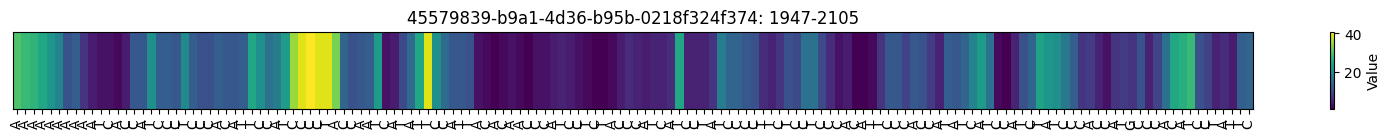

In [54]:
p = stats.predicts_with_chop[0]
vis_qual_static(all_predicts[p], stats.smooth_intervals[p][0][0] - 10 , stats.smooth_intervals[p][0][1] + 10)

In [ ]:
original_prediction_number = stats.number_predicts_with_chop(all_predicts)
smooth_prediction_number = stats.number_smooth_predicts_with_chop()

fig, axs = plt.subplots(1, 2, figsize=(18, 6))
vis_hist_for_num_of_intervals(original_prediction_number, title="Original Intervals", ax=axs[0])
vis_hist_for_num_of_intervals(smooth_prediction_number, title="Smooth Intervals", ax=axs[1])

In [ ]:
len(stats.smooth_only_one_with_ploya)

In [ ]:
plot_oregion_size_data = stats.length_predicts_with_chop(all_predicts)
plot_sregion_size_data = stats.lenghth_smooth_predicts_with_chop()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(18, 6))
vis_hist_for_num_of_intervals(plot_oregion_size_data, title=f"Chop Size of clean data (original) {min(plot_oregion_size_data)}-{max(plot_oregion_size_data)}", ax=axs[0])
vis_hist_for_num_of_intervals(plot_sregion_size_data, title=f"Chop Size of clean data (smooth) {min(plot_sregion_size_data)}-{max(plot_sregion_size_data)}", ax=axs[1])

In [54]:
len(stats.smooth_only_one)

13655

In [55]:
len(stats.smooth_predicts_with_chop)

13878

In [41]:
def show_examples(predcit_ids, all_predicts, stats):
    for predict_id in predcit_ids:
        predict = all_predicts[predict_id]
        
        smooth_regs = stats.smooth_intervals.get(predict_id, [])
        print(predict.show_info(smooth_regs))

In [29]:
show_examples(set(stats.smooth_predicts_with_chop) - set(stats.smooth_only_one), all_predicts, stats)

id: 110600e3-9f28-4241-b251-97da6085885f
prediction: [889..959, 2024..2092, 2093..2094, 2095..2096, 2097..2099]
smooth_intervals: [(889, 959), (2024, 2099)]
GTTCTGCCGTCCTGGGGCGGGGGACGTTTTGGACAGTGGGGTAAACTGAGGCCCGATAGGGGCGCTAGGCACTGCCCGGA
GTCCGGCGCGCACGGATTGAGGCGACCTGATTCCGCCGCATCCTGGCCCGCGCGGCGAGTGTGGTCTCTGGGCTCGGGAC
CTGACTTCTGGCCTGGGGGCCGTGCACCGGCAGCGCAGGATTCAGCCTCTTCCAACTGGCCCTGAGACCACTTTGCGACT
GACCCCGGAGGCTGGAATGCAGTGGTGTGATCTTGGCTCACTGCAGCCTCTACCACCTGGGCTCAAGCAATCTTCCCACC
TCGGCCTCCCAAGTAGCTGGAACTACAGGTGGCCCCAAATCCAAGCAATCCTTATAAGAGAGAGACAGAGGGAGATTTGA
GAGACAGAAGAGGAGGAGGTGATCTGATTACAGAGGCGGAGACGGGTAATGCCCATGCGCCCGAGTTCCCCGGCAGCCAC
TGGAAGCTGGAGAGGTGAGGAGTCGCCCAGGAGGCCCTGAGGGAGCTAGATCAAGTTGCGGCCTCCAGAACTCCAGAGAG
AATGAATGTCTGCTGTTCTCAGCACCCCTCCGTGGTCCTCTGTCACGGCAGCCGCGGGACCCTCACGCGCTGTCTGGGCC
GTCCCTTCCAGCGTGTCGGGCGTTGTGTCCAGCACTGGGACCGCCCTCAGGCGTGACTTGAGCCCTGTTCCAGCCTCTGC
GCGGGGTTGCCCAGACGCCCCTCCAGGGCGTGATGCCACTGCCCCTGGTGGCCGCGGCTGCCCAGACGCCTCTCCTCGCA
GACCCAGCACCGCCAGCACTTGGGAACCAGCTC

In [ ]:
overlap_results.keys()

In [ ]:

def get_acc(data):
    internal_chop_sc_count = len(data.get("internal_chop_sc", []))
    internal_chop_nosc_count = len(data.get("internal_chop_nosc", []))
    internal_chop_nosc_noblat_count = len(data.get("internal_chop_nosc_noblat", []))
    internal_chop_nosc_cannotblat_count = len(
        data.get("internal_chop_nosc_cannot_blat", [])
    )
    total_internal = internal_chop_sc_count + internal_chop_nosc_count
    confirmed_internal = internal_chop_sc_count + internal_chop_nosc_noblat_count

    internal_acc = confirmed_internal / (total_internal)

    terminal_chop_sc_count = len(data.get("terminal_chop_sc", []))
    terminal_chop_nosc_count = len(data.get("terminal_chop_nosc", []))
    terminal_chop_nosc_noblat_count = len(data.get("terminal_chop_nosc_noblat", []))
    terminal_chop_nosc_cannotblat_count = len(
        data.get("terminal_chop_nosc_cannot_blat", [])
    )
    total_terminal = terminal_chop_sc_count + terminal_chop_nosc_count
    confirmed_terminal = terminal_chop_sc_count + terminal_chop_nosc_noblat_count

    terminal_acc = confirmed_terminal / (total_terminal)

    total_acc = (confirmed_internal + confirmed_terminal) / (
        total_internal + total_terminal
    )

    return internal_acc, terminal_acc, total_acc


def vis_overlap_results(data):
    import pandas as pd

    internal_acc, terminal_acc, total_acc = get_acc(data)

    plot_df = pd.DataFrame(
        [(key, len(value)) for key, value in data.items()],
        columns=["Category", "Count"],
    )

    # Plotting the data
    plt.figure(figsize=(10, 6))  # Set the figure size
    bars = plt.bar(
        plot_df["Category"], plot_df["Count"], color="skyblue"
    )  # Create a bar chart
    # Add text annotations to the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            yval + 0.5,
            yval,
            ha="center",
            va="bottom",
        )

    plt.xlabel("Category")  # Set the x-label
    plt.ylabel("Number of Items")  # Set the y-label
    plt.title(
        f"Count of Items in Each Category {internal_acc=:.4f} {terminal_acc=:.4f} {total_acc=:.4f}"
    )  # Set the title
    plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better visibility
    plt.tight_layout()  # Adjust layout to make room for the rotated x-labels
    plt.show()  # Display the plot
    plt.close()

In [76]:
# from collections import defaultdict
# ps  = stats.smooth_predicts_with_chop

# overlap_results  = defaultdict(list)
# # ps = set(os) - set(stats.smooth_internal_predicts)
# for p in ps:
#     pd = all_predicts[p]
#     # sreg = stats.smooth_intervals.get(p, [])
#     # if len(sreg) > 2:
#         # show_sam_record(pd, stats, sam_records)
#         # print("\n")
#         # print(pd.show_info(sreg))
    
#     verify_result_with_sam_records(
#     overlap_results,
#     pd,
#     stats,
#     sam_records,
#     internal_threshold = 0.85,
#     overlap_threshold  = 0.4,
#     blat_threshold  = 0.9,
#     min_mapping_quality = 0)

In [ ]:
stats

In [ ]:
vis_overlap_results(overlap_results)

In [105]:
selected = set(overlap_results["internal_chop_nosc"])  - set(overlap_results["internal_chop_nosc_noblat"] + overlap_results["internal_chop_nosc_cannot_blat"])

for value in selected:
        pd = all_predicts[value]
        
        verify_result_with_sam_records_rs(
        defaultdict(list),
        pd,
        stats,
        rs_sam_records[value],
        internal_threshold = INTERNAL_THRESHOLD, # change to 0.9
        overlap_threshold  = OVERLAP_THRESHOLD,
        blat_threshold  = BLAT_THRESHOLD,
        min_mapping_quality = MIN_MAPPING_QUALITY)


Thu Apr 25 01:46:14 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.




id: ff80f738-3bf5-4f40-b247-a2aabc9798ba
prediction: [507..574, 576..579, 965..966, 985..986, 990..993, 999..1003]
smooth_intervals: [(507, 577)]
TGCCGCCAAGGTGCTCGGTCCTTCCGAGGAAGCTAAGGCTGCGCTGGGGTGAGGCCCACCACTTCATCCGGCGACTAGCA
CCGCGTCCGGCAGCGCCAGCCCTACACTCGCCCGCGCCATGGCCCTTTGTTTCCGAGCTCGCCTGCATCTACTCGGCCCT
CATTCTGCACGACGATGAGGTGACAGTCACGGAGGATAAGATCAATGCCCCTTTAAAGCAGCCGGTGTAAATGCTGAGCC
TTTTTGGCCTGGCTTGTTTGCAAAGGCCCTGGCCAACGTCAACAAAAGGAGCCTCATCTGCAATGTAGGGGCCGGTGGAC
CTGCTCCAGCAGCTGGTGCTGCACCAGCAGGAGGTCCTGCCCCCTCCACTGCTGCTGCTCCAGCTGAGGAGAAGAAAGTG
GAAGCAAAGAAAGAAGAATCCGAGGAGTCTGATGATGACATAGGCTTTGGTCTCTTGACTAAACCTTTCTATATCGTCAA
TAAAAAGCTGAACTTTAAAAAAAAAAATCCCTCCCACTCCCATATCACTCCTACCGTCATCATCCATATTATCATCCCAC
ATCCCTATCACCCCCCTCCGCCACCCCAGTTGCTGCTTGCTGTGAGTGTTTCACTAGGGTGATACGTGGGTGAGAAGGTC
CTGGTCCGCGCCAGAGCCCAGCGCGCCTCGTCGCCATGCCTCGGAAAATTGAGGAAATCAAGGACTTCCTGCTCAGCCCG
ATGAAAGGATGCCAAATCTGTCAAGATCAAGAAAAATAAGGACAACGTGAAGTTTAAAAGTTCGATGCAGCAGATACCTT
TACACCCTGGTCATCACTGACAAAGAGAAGGCAGAGAAACTG

Thu Apr 25 01:46:15 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.



blat_df:   genome  query_size  aligned_start  aligned_end  matches  mismatches  %_aligned  %_matched chromosome strand      start        end
0   hg38          70              5           68       36           0      91.43      56.25       chr5      +  131362146  131362578
1   hg38          70             30           49       20           0      28.57     100.00       chr9      -  119249489  119249508



id: 2b2708bd-5dee-4163-bdd6-184da9328f63
prediction: [229..259, 260..263, 274..275, 2775..2837]
smooth_intervals: [(229, 262), (2775, 2837)]
AAATCTTATTGTGGGTCCAGTGAGACCATCTCATCCAAAAGATTTTTTTTCCCCAATGATGTTTGCTTTAGAAGCAAGAT
AGAAAGGAAAAAAAGTATTAGGTAGATATGTATAGTAGGGACAGAGGGAAATCTTTCTTCTTTCCTTGAAAGTAATACTT
CTTGTTACACATATTTTATTTATTGAGTTTGTTCTAAATAAAATATTATAAACTTCAGACTTGAAAAAATTCCACTTAAC
TTTAAAGTTACAATGTTTGTATTTGGGATTTTAAATGCCTTTGAGATTAAAATGTAGAATTGCAGGACCCAAAAACTTTT
AAAATAATTAAAATTTTAAAAGAGCACATGTTGTGTTTTTTGGGCTTGCTATTAATGCAAACTCTGATTGCAATGGATGT
CATGTTTCATACCTTTTTTATCAGGAAAAAAGCAGCAAGCCTCAG

Thu Apr 25 01:46:15 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.



blat_df:   genome  query_size  aligned_start  aligned_end  matches  mismatches  %_aligned  %_matched chromosome strand      start        end
0   hg38          33              1           33       33           0      100.0      100.0       chr5      +  134857161  134857193

compare (2769, 2837)(68) (2775, 2837)(62) ratio=1.0


id: 4b0b034a-53ef-46bc-b6f8-1073914fe103
prediction: [510..547, 550..552, 553..555, 578..579, 580..626]
smooth_intervals: [(510, 551), (579, 626)]
CAGGACAACGAGCTGGCGGCACTCGCGCCGGGGCTGCTGGGCCGCCTGCCCGCTCTAGACGCGCTGCACCTGCGCGGCAT
CCTGGGCCATGCGGGTGCGCGCTGCGCCCATTCGGCAAGCTGCGCCGGCACCCGCTGCCCGCGTCAGAGGCCGAGACGGT
GCTCTGCGTGTGGCCGGGACGCCTGACGCCCTGTCCCCTGACTGCCTTTTCCGACGCCGCCTTTAGCCATTGCGCGCAGC
CGCTCGCCCTGCAGGACCTGGCCGTGGTTCACACGCTCGGGCCGGCCTCCTCGTCAGCCTGGCTCCTCTGCCTGGCGCTG
GGCTCTTGGGCTCACCGCCTGCCGTGCGCCGCCGCCGCCTCCGCACCGCCGCCCTCCGCCCGCCGAGACCGCCAGACCCG
AACCCGATCCCGACCCCCACGGCTGTCGCCCACGCCCGCGGACCCGGGGAGCCCCGCCGCTGCCGCCCAAGCCTGAGCGG
CCGCGAGCCGCCTGGAGCGCTCAAAAAAAATCCCCCAT

In [106]:
# # overlap_results
# for key, values in overlap_results.items():
#     # if key not in ["internal_chop_sc",  "terminal_chop_sc", "unmap_read", 
#     #                # "internal_chop_nosc",
#     #                # "terminal_chop_nosc"
#     #               ]:
#     if (key in ["internal_chop_nosc", "terminal_chop_nosc"]) and (key not in ["internal_chop_nosc_noblat", "terminal_chop_nosc_noblat"]):
        
#         for value in values:
#             print(f"\n{key}")
#             pd = all_predicts[value]
            
#             verify_result_with_sam_records_rs(
#             defaultdict(list),
#             pd,
#             stats,
#             rs_sam_records[value],
#             internal_threshold = INTERNAL_THRESHOLD, # change to 0.9
#             overlap_threshold  = OVERLAP_THRESHOLD,
#             blat_threshold  = BLAT_THRESHOLD,
#             min_mapping_quality = MIN_MAPPING_QUALITY)
    
#             # show_sam_record(pd, stats, sam_records)